In [1]:
import math

from src.utils.io import load_results
from matplotlib import pyplot as plt
import collections
import os
from collections import deque
import seaborn as sns


import cv2
import numpy as np
import pandas as pd
import time
import zwoasi as asi
from src.camera.camera_setup import setup_camera
from src.camera.camera_stream import CameraStream
from src.camera.image_processing import get_clean_frame, \
    get_contours, get_contour_origin, get_largest_contour
from src.fsm.fsm_calibration import get_fsm_roi_and_amplitude_bounds, get_response_time
from src.camera.camera_calibration import set_roi
from src.fsm.fsm_setup import setup_fsm
from src.utils.general import wait
from src.utils.io import save_results
from src.fsm.fsm import FSM
import random
root_dir = os.path.dirname(os.getcwd())
from src.utils.spectral_analysis import get_frequencies_and_amplitudes, get_distinct_peak_indices
from src.utils.general import show_images




### Camera Setup

In [2]:
BINS = 2
GAIN = 120
EXPOSURE = 32  # µs
MAX_RESOLUTION = (int(8288 / BINS), int(5640 / BINS))
RESOLUTION = MAX_RESOLUTION
START_POS = (0, 0)
FRAMES_DARK = 10
BUFFER_CAPACITY = 1
COLOUR: bool = False
# Contour mode for finding center of brightest point, if false cv2.minMaxLox will be used
CONTOUR_MODE: bool = True
CAMERA_ID: int = 0
SDK_LIB_NAME: str = 'libASICamera2.dylib'
camera, master_dark = setup_camera(root_dir= root_dir,
                                   sdk_lib_name= SDK_LIB_NAME,
                                   camera_id= CAMERA_ID,
                                   bins=BINS,
                                   gain=GAIN,
                                   exposure=EXPOSURE,
                                   resolution= RESOLUTION,
                                   start_pos= START_POS,
                                   dark_frames= FRAMES_DARK, )
camera_stream = CameraStream(camera)

Setting up camera
Resetting Camera setting to default
Settings Reset to Default

Setting camera ROI
ROI Set:
    Start X: 0
    Start Y: 0
    Resolution: 4144x2820
    Bins: 2

Using provided gain & exposure settings
Gain: 120, Exposure: 32µs

Controls
    AutoExpMaxExpMS
      - ControlType 11
      - DefaultValue 100
      - Description 'Auto exposure maximum exposure value(unit ms)'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 60000
      - MinValue 1
      - Name 'AutoExpMaxExpMS'
    AutoExpMaxGain
      - ControlType 10
      - DefaultValue 285
      - Description 'Auto exposure maximum gain value'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 570
      - MinValue 0
      - Name 'AutoExpMaxGain'
    AutoExpTargetBrightness
      - ControlType 12
      - DefaultValue 100
      - Description 'Auto exposure target brightness value'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 160
      - MinValue 50
      

In [16]:
camera.close()

### FSM setup

In [3]:
PORT: str = "/dev/cu.usbmodem00000000001A1"
BAUDRATE: int = 256000
TIMEOUT: int = 1
fsm_controller = setup_fsm(PORT, BAUDRATE, TIMEOUT)

Setting up FSM/n
Connected to FSM on /dev/cu.usbmodem00000000001A1 & write thread started 

Status: (Should be 0000000000 signalling no issues)
Sent: status
Received: 
0000000000
Sent: acknowledge
Received: 
OK
Sent: start
Received: 
OK
Sent: xy=0;0
Received: 
OK


In [17]:
fsm_controller.disconnect()

Disconnected from FSM



### Recreation of movement noise

In [ ]:
results = load_results(root_dir, "optotune_fsm_square_.04A_KF0_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_MOU0.05_MEU0.5_C1_K3.csv", "2025-08-04")
time_results = results["Time"]
x_results = results["X"]
y_results = results["Y"]
print(f"Samples: {len(results)}")
print(f"Time: {max(time_results)}")
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
axes[0].plot(time_results, x_results,color="g")
axes[0].set_title(f"X Axis Position of Laser Dot over Time")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel(f"X Values   (Var: {x_results.var():.4f})")


axes[1].plot( results["Time"], y_results, label=f"Variance {y_results.var()}",  color="b")
axes[1].set_title(f"Y Axis Position of Laser Dot over Time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel(f"Y Values    (Var: {y_results.var():.4f})")

plt.show()


### Extracting predicted frequency of movement noise aswell as distinct frequencys

In [ ]:
num_std_devs = 1
height = 0.5
x_frequencies, x_amplitudes = get_frequencies_and_amplitudes(x_results, np.array(time_results))
x_dominant_frequency = x_frequencies[np.argmax(x_amplitudes)]
x_distinct_peak_indices = get_distinct_peak_indices(x_frequencies, x_amplitudes, num_std_devs, height)
plt.plot(x_frequencies, x_amplitudes,  color='r')
plt.plot(x_frequencies[x_distinct_peak_indices], x_amplitudes[x_distinct_peak_indices],  'yo', label= "Distinct Frequencies")

plt.title('FTT X')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.axvline(x_dominant_frequency, color='g', linestyle=':', label=f'Peak at {x_dominant_frequency:.2f} Hz')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_frequencies, y_amplitudes = get_frequencies_and_amplitudes(y_results, np.array(time_results))
y_dominant_frequency = y_frequencies[np.argmax(y_amplitudes)]
y_distinct_peak_indices = get_distinct_peak_indices(y_frequencies, y_amplitudes, num_std_devs, height)
plt.plot(y_frequencies, y_amplitudes,  color='r')
plt.plot(y_frequencies[y_distinct_peak_indices], y_amplitudes[y_distinct_peak_indices],  'yo'
         ,label= "Distinct Frequencies")

plt.title('FTT Y')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.axvline(y_dominant_frequency, color='g', linestyle='--', label=f'Peak at {y_dominant_frequency:.2f} Hz')
plt.legend()

plt.tight_layout()
plt.show()

### Error of actual frequency of movement noise and predicted frequency of noise

In [ ]:
actual_frequency = 1.0
dominant_frequency = (x_dominant_frequency + y_dominant_frequency) / 2
error = (abs(dominant_frequency - actual_frequency) / actual_frequency) * 100
print(f"Error: {error:.2f}%")

### Intensity varation with power of laser

In [ ]:
current = 0.003
current_unit: str = "A"
frames = 10
clean_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(frames)]
clean_image = np.median(clean_frames, axis = 0).astype(np.uint8)
contours = get_contours(clean_image)
if contours:
    lazer_blob = get_largest_contour(contours)
    mask = np.zeros(clean_image.shape, dtype=np.uint8)
    cv2.drawContours(mask,
                     [lazer_blob],
                     -1,
                     255,
                     thickness=cv2.FILLED)
    area = cv2.contourArea(lazer_blob) # Measured in pixels
    mean, std_dev = cv2.meanStdDev(clean_image, mask=mask)
    show_images(clean_image, mask, title= f"Mean: {mean[0,0]:.5f}, Standard Deviation: {std_dev[0,0]:.5f}, Area (pxl): {area}, Current: {current}{current_unit}")
else:
    area = 0.0
    mean = 0.0
    std_dev = 0.0
    show_images(clean_image, title= f"Couldn't find any contours, Mean: {mean:.5f}, Standard Deviation: {std_dev:.5f}, Area (pxl): {area}, Current: {current}{current_unit}")

### Intensity Results

In [ ]:
camera.close()

In [ ]:
error, mean, std_dev, current, area

In [ ]:
intensity_results = pd.DataFrame({
    "Frequency Error" : [
        48.2079, 71.3417, 74.1141, 3.017, 5.4405,
        4.2509, 0.7987, 4.1856, 2.6212, 1.2864,
        2.0884, 2.8698, 0.0767, 8.2045, 3.1407

    ],
    "Mean Intensity" : [
        0.0, 0.0, 0.0, 0.9962, 1.3467,
        2.6624, 9.1747, 19.4470, 34.7310, 52.8142,
        78.3584, 111.0976, 156.9581, 184.3910, 205.3289

    ],
    "Standard Deviation Intensity" : [
        0.0, 0.0, 0.0, 0.0613, 0.5073,
        0.7638, 3.4061, 7.5715, 12.5792, 20.0336,
        29.5215, 42.8003, 57.7703, 58.9460, 53.4733

    ],
    f"Current (A)" : [
        0.0, 0.001, 0.002, 0.003, 0.004,
        0.005, 0.01, 0.015, 0.02, 0.025,
        0.03, 0.035, 0.04, 0.045, 0.05

    ],
    f"Area (pxl)" : [
        0.0, 0.0, 0.0, 2021.0, 5292.0,
        4168.0, 6281.5, 6855.5, 6415.0, 6812.0,
        6810.5, 7013.0, 7178.0, 8979.5, 11202.0
    ]
})

### Measuring optical power with current

In [ ]:
# At a power of 0.0 uW the current is also 0.0 A

power_current_measurements = pd.DataFrame({
    "Power (uW)" : [
        0.00348, 0.01442, 0.0338, 0.0578,
        0.0895, 0.317, 0.652, 1.106, 1.718,
        2.55, 3.74, 5.55, 8.47, 13.82
    ],
    f"Current (A)" : [
        0.001, 0.002, 0.003, 0.004,
        0.005, 0.01, 0.015, 0.02, 0.025,
        0.03, 0.035, 0.04, 0.045, 0.05
    ],
})
n = len(power_current_measurements)
k = sum([
    (power_current_measurements["Power (uW)"][i] / power_current_measurements["Current (A)"][i])
    for i in range(n)
]) / n
print(f"Constant: {k: .6f}")

In [ ]:
power = True

x_axis_unit = "uW" if power else "A"
x_axis_label= "Power" if power else "Current"
x_axis_data = intensity_results["Current (A)"] * k
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(x_axis_data, intensity_results["Frequency Error"], color='blue')
axes[0, 0].set_title(f"Frequency Error vs {x_axis_label}")
axes[0, 0].set_ylabel("Frequency Error")
axes[0, 0].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[0, 0].grid(True)

axes[0, 1].plot(x_axis_data, intensity_results["Mean Intensity"], color='green')
axes[0, 1].set_title(f"Mean Intensity vs {x_axis_label}")
axes[0, 1].set_ylabel("Mean Intensity")
axes[0, 1].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[0, 1].grid(True)

axes[1, 0].plot(x_axis_data, intensity_results["Standard Deviation Intensity"], color='red')
axes[1, 0].set_title(f"Standard Deviation Intensity vs {x_axis_label}")
axes[1, 0].set_ylabel("Standard Deviation Intensity")
axes[1, 0].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[1, 0].grid(True)

axes[1, 1].plot(x_axis_data, intensity_results["Area (pxl)"], color='purple')
axes[1, 1].set_title(f"Area vs {x_axis_label}")
axes[1, 1].set_ylabel("Area (pxl)")
axes[1, 1].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


### Plots that are independent of the area of the lazer

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

coefficient_of_variance = intensity_results["Standard Deviation Intensity"] / (intensity_results["Mean Intensity"] + 1e-9)
axes[0].plot(x_axis_data, coefficient_of_variance, color='blue')
axes[0].set_title(f"Coefficient of Variance vs {x_axis_label}")
axes[0].set_ylabel("Coefficient of Variance")
axes[0].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[0].grid(True)

total_flux = intensity_results["Mean Intensity"] * intensity_results["Area (pxl)"]
axes[1].plot(x_axis_data, total_flux, color='green')
axes[1].set_title(f"Total Flux vs {x_axis_label}")
axes[1].set_ylabel("Total Flux")
axes[1].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Testing how frequency changes over time with amplitude

In [ ]:
results_2 = load_results(root_dir, "square_A1.0Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_1_75 = load_results(root_dir, "square_A1.75Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_1_5 = load_results(root_dir, "square_A1.5Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_1_25 = load_results(root_dir, "square_A1.25Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_1 = load_results(root_dir, "square_A1.0Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_75 = load_results(root_dir, "square_A.75Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_5 = load_results(root_dir, "square_A.5Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_25 = load_results(root_dir, "square_A.25Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_15 = load_results(root_dir, "square_A.15Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_05 = load_results(root_dir, "square_A.05Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_025 = load_results(root_dir, "square_A.025Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_001 = load_results(root_dir, "square_A.001Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")

dict_results = {2.0 : results_2,
                1.75 : results_1_75,
                1.5 : results_1_5,
                1.25 : results_1_25,
                1.0 : results_1,
                0.75 : results_0_75,
                0.5 : results_0_5,
                0.25 : results_0_25,
                0.15 : results_0_15,
                0.05 : results_0_05,
                0.025 : results_0_025,
                0.001 : results_0_001
                }

In [ ]:
window_size = 100
dict_final_results = {}
for r_key in dict_results.keys():
    final_results = []
    r = dict_results[r_key]
    x_results = np.array(r["X"])
    y_results = np.array(r["Y"])
    times = np.array(r["Time"])
    for i in range(len(r) // window_size):
        start_idx = i * window_size
        if (i + 1) < len(r) // window_size:
            end_idx = start_idx + window_size
        else:
            end_idx = len(r) - 1
        x_frequencies, x_amplitudes = get_frequencies_and_amplitudes(np.array(x_results[start_idx:end_idx]), np.array(times[start_idx:end_idx]))
        y_frequencies, y_amplitudes = get_frequencies_and_amplitudes(np.array(y_results[start_idx:end_idx]), np.array(times[start_idx:end_idx]))
        final_results.append(
            (x_frequencies[np.argmax(x_amplitudes)],
             y_frequencies[np.argmax(y_amplitudes)],
             times[end_idx])
        )
    dict_final_results[r_key] = final_results

fig, axes = plt.subplots(len(dict_final_results), 1 , figsize=(15, 45))

for i, final_result_key in enumerate(dict_final_results.keys()):
    final_result = dict_final_results[final_result_key]
    x_dominant_frequencies, y_dominant_frequencies, times = zip(*final_result)
    x_variance = np.var(x_dominant_frequencies)
    y_variance = np.var(y_dominant_frequencies)
    x_mean = np.mean(x_dominant_frequencies)
    y_mean = np.mean(y_dominant_frequencies)
    axes[i].set_title(f"{i+1}. Amplitude {final_result_key} Vpp")

    axes[i].plot(times, x_dominant_frequencies, color='r', label=f'X Dominant Frequency, Variance: {x_variance:.6f}, Mean: {x_mean:.6f}')
    axes[i].plot(times, y_dominant_frequencies, color='b', label=f'Y Dominant Frequency, Variance: {y_variance: .6f}, Mean: {y_mean:.6f}')

    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Frequency (Hz)')
    axes[i].grid(True)
    axes[i].legend()

fig.suptitle('Dominant Frequency vs Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
dict_final_results = {}
for r_key in dict_results.keys():
    r = dict_results[r_key]
    x_results = np.array(r["X"])
    y_results = np.array(r["Y"])
    times = np.array(r["Time"])
    x_frequencies, x_amplitudes = get_frequencies_and_amplitudes(np.array(x_results), np.array(times))
    y_frequencies, y_amplitudes = get_frequencies_and_amplitudes(np.array(y_results), np.array(times))

    dict_final_results[r_key] = (x_frequencies[np.argmax(x_amplitudes)],
         y_frequencies[np.argmax(y_amplitudes)],)

actual_frequency = 1.0
x_dominant_frequencies, y_dominant_frequencies = zip(*dict_final_results.values())
x_error = (abs(np.array(x_dominant_frequencies) - actual_frequency) / actual_frequency) * 100
y_error = (abs(np.array(y_dominant_frequencies) - actual_frequency) / actual_frequency) * 100

plt.plot(dict_final_results.keys(), x_error, color='r', label=f'X Frequency Error')
plt.plot(dict_final_results.keys(), y_error, color='b', label=f'Y Frequency Error')
plt.legend()
plt.gca().invert_xaxis()
plt.title("Frequency Error vs Input Amplitude")
plt.xlabel("Input Amplitude (Vpp)")
plt.ylabel("Frequency Error (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Testing movement of FSM laser point

In [ ]:
origin_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(10)]
origin_image = np.median(origin_frames, axis = 0).astype(np.uint8)


o_contours = get_contours(origin_image)
o_largest_contour = get_largest_contour(o_contours)
origin_x, origin_y = get_contour_origin(o_largest_contour)

origin_image = cv2.cvtColor(origin_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(
    image=origin_image,
    contours=o_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=8
)
cv2.circle(
    img=origin_image,
    center=(int(origin_x), int(origin_y)),
    radius=20,
    color=(255, 0, 0),
    thickness=-1
)

amplitude = 0.02
fsm_controller.send_command(f"x={amplitude}")


calibrate_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(10)]
calibrate_image = np.median(calibrate_frames, axis = 0).astype(np.uint8)

c_contours = get_contours(calibrate_image)
c_largest_contour = get_largest_contour(c_contours)
calibrate_x, calibrate_y = get_contour_origin(c_largest_contour)

calibrate_image = cv2.cvtColor(calibrate_image, cv2.COLOR_GRAY2BGR)

cv2.drawContours(
    image=calibrate_image,
    contours=c_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=8
)
cv2.circle(
    img=calibrate_image,
    center=(int(calibrate_x), int(calibrate_y)),
    radius=20,
    color=(255, 0 ,0),
    thickness=-1
)

delta_x = abs(origin_x - calibrate_x)
delta_y = abs(origin_y - calibrate_y)

if delta_x == 0:
    delta_x += 1
print(f"APP X: {amplitude / delta_x} Y: {amplitude / delta_y}")

show_images(origin_image, calibrate_image, )
print(f"ORi, X: {origin_x} Y: {origin_y}"
      f"CAL, X: {calibrate_x} Y: {calibrate_y}")
fsm_controller.send_command("xy=0;0")

### Plotting beam movement with a changing amplitude/angle

In [ ]:
results = load_results(root_dir, "distance_vs_amplitude_.04A_KF0_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_MOU0.1_MEU2_C1_K3.csv", "2025-08-08")
angles = []
amplitude = 0.0
for _ in results.index:
    angles.append(math.degrees(math.atan(amplitude * math.tan(math.radians(50)))))
    amplitude += 0.00001
fig, ax = plt.subplots(2, 1, figsize = (12, 12))
ax[0].plot(angles, results["delta_x"])
ax[0].set_xlabel("Angle (degrees)")
ax[0].set_ylabel("Change in pixels (x axis)")
ax[0].grid()

ax[1].plot(angles, results["delta_y"])
ax[1].set_xlabel("Angle (degrees)")
ax[1].set_ylabel("Change in pixels (y axis)")
ax[1].grid()
plt.show()


Loading Results
Loaded noise_reduction_sine_.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM0_MOU0.05832_MEU0.00125_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-19

Loading Results
Loaded noise_reduction_sine_.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-19



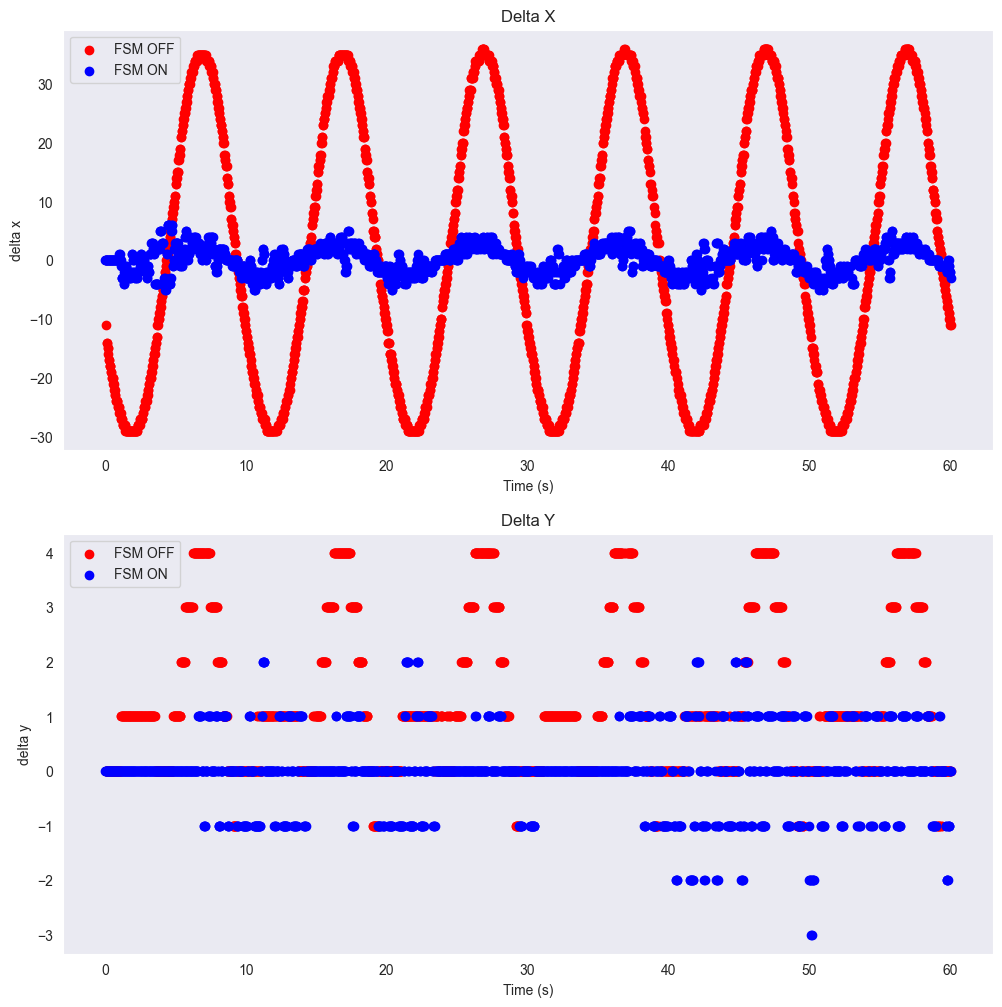

In [12]:
baseline_results = load_results(root_dir, "noise_reduction_sine_.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM0_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
results = load_results(root_dir, "noise_reduction_sine_.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")

fig, axis = plt.subplots(2, 1, figsize = (12, 12))
axis[0].scatter(baseline_results["Time"], baseline_results["delta_x"],  color = "r", label = "FSM OFF")
axis[0].scatter(results["Time"], results["delta_x"],  color = "b", label = "FSM ON")
axis[0].set_ylabel("delta x")
axis[0].set_xlabel("Time (s)")
axis[0].set_title("Delta X")
axis[0].grid()
axis[0].legend()

axis[1].scatter(baseline_results["Time"], baseline_results["delta_y"], color = "r", label = "FSM OFF")
axis[1].scatter(results["Time"], results["delta_y"], color = "b", label = "FSM ON")
axis[1].set_title("Delta Y")
axis[1].set_ylabel("delta y")
axis[1].set_xlabel("Time (s)")
axis[1].grid()
axis[1].legend()

plt.show()

In [ ]:
bin2_pixel_size = 4.63 #um

fig, ax = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle('Distribution of Tracking Error', fontsize=16)

displacement_x = np.array([2 * math.atan((abs(delta_pos) * bin2_pixel_size) / (2 * (6459 * 1e3))) * 1e6 for delta_pos in results["delta_x"]])
displacement_y = np.array([2 * math.atan((abs(delta_pos) * bin2_pixel_size) / (2 * (6459 * 1e3))) * 1e6 for delta_pos in results["delta_y"]])
baseline_displacement_x = np.array([2 * math.atan((abs(delta_pos) * bin2_pixel_size) / (2 * (6459 * 1e3))) * 1e6 for delta_pos in baseline_results["delta_x"]])
baseline_displacement_y = np.array([2 * math.atan((abs(delta_pos) * bin2_pixel_size) / (2 * (6459 * 1e3))) * 1e6 for delta_pos in baseline_results["delta_y"]])

ax1 = ax[0, 0]
ax1.hist(displacement_x, bins=50, density=True, color='skyblue', edgecolor='black')
ax1.set_title('X-Axis Displacement Distribution (FSM ON)')
ax1.set_xlabel('Error from Origin (urad)')
ax1.set_ylabel('Probability Density')
ax1.grid(True)
mean_x = displacement_x.mean()
std_x = displacement_x.std()
ax1.axvline(mean_x, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_x:.2f}')
ax1.axvline(mean_x + std_x, color='orange', linestyle=':', linewidth=2, label=f'Std Dev: {std_x:.2f}')
ax1.axvline(mean_x - std_x, color='orange', linestyle=':', linewidth=2)
ax1.legend()

ax2 = ax[1, 0]
ax2.hist(displacement_y, bins=50, density=True, color='lightgreen', edgecolor='black')
ax2.set_title('Y-Axis Displacement Distribution (FSM ON)')
ax2.set_xlabel('Error from Origin (urad)')
mean_y = displacement_y.mean()
std_y = displacement_y.std()
ax2.axvline(mean_y, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_y:.2f}')
ax2.axvline(mean_y + std_y, color='orange', linestyle=':', linewidth=2, label=f'Std Dev: {std_y:.2f}')
ax2.axvline(mean_y - std_y, color='orange', linestyle=':', linewidth=2)
ax2.legend()
ax2.grid(True)

ax3 = ax[0, 1]
ax3.hist(baseline_displacement_x, bins=50, density=True, color='skyblue', edgecolor='black')
ax3.set_title('X-Axis Displacement Distribution (FSM OFF)')
ax3.set_xlabel('Error from Origin (urad)')
ax3.set_ylabel('Probability Density')
ax3.grid(True)
mean_x = baseline_displacement_x.mean()
std_x = baseline_displacement_x.std()
ax3.axvline(mean_x, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_x:.2f}')
ax3.axvline(mean_x + std_x, color='orange', linestyle=':', linewidth=2, label=f'Std Dev: {std_x:.2f}')
ax3.axvline(mean_x - std_x, color='orange', linestyle=':', linewidth=2)
ax3.legend()

ax4 = ax[1, 1]
ax4.hist(baseline_displacement_y, bins=50, density=True, color='lightgreen', edgecolor='black')
ax4.set_title('Y-Axis Displacement Distribution (FSM OFF)')
ax4.set_xlabel('Error from Origin (urad)')
mean_y = baseline_displacement_y.mean()
std_y = baseline_displacement_y.std()
ax4.axvline(mean_y, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_y:.2f}')
ax4.axvline(mean_y + std_y, color='orange', linestyle=':', linewidth=2, label=f'Std Dev: {std_y:.2f}')
ax4.axvline(mean_y - std_y, color='orange', linestyle=':', linewidth=2)
ax4.legend()
ax4.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Testing to get minimum fsm down time between movement and camera capture

In [ ]:
r0_1 = load_results(root_dir, "noise_reduction_sine_ST0.1.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r0_15 = load_results(root_dir, "noise_reduction_sine_ST0.15.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r0_2 = load_results(root_dir, "noise_reduction_sine_ST0.2.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r0_05 = load_results(root_dir, "noise_reduction_sine_ST0.05.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r0_075 = load_results(root_dir, "noise_reduction_sine_ST0.075.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r_0_08125 = load_results(root_dir, "noise_reduction_sine_ST0.08125.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r0_09 = load_results(root_dir, "noise_reduction_sine_ST0.09.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
results = {
    "0.1" : r0_1,
    "0.15" : r0_15,
    "0.2" : r0_2,
    "0.075" : r0_075,
    "0.08125" : r_0_08125,
    "0.09" : r0_09
}

results = {float(key) : np.sqrt(np.mean(results[key]['delta_x'], axis = 0)**2 + np.mean(results[key]['delta_y'], axis = 0)**2) for key in results.keys()}
print(results)

plt.scatter(results.keys(), results.values())
plt.ylabel("RMS Error")
plt.xlabel("Wait Times (s)")

plt.show()


In [ ]:
results = load_results(root_dir, "tracking_.04A_KF0_G120_E32_B2_R(4144, 2820)_S(0, 0)_FSM0_MOU1e-06_MEU5_.csv", "2025-08-22")

Q1 = results.quantile(0.25)
Q3 = results.quantile(0.75)
IQR = Q3 - Q1

results = results[~((results < (Q1 - 1.5 * IQR)) | (results > (Q3 + 1.5 * IQR))).any(axis=1)]
fig, axis = plt.subplots(2, 1, figsize = (12, 12))
ax1 = axis[0]
ax1.scatter(results["estimated_X"], results["estimated_Y"],  color = "r")
ax1.set_ylabel("Y")
ax1.set_xlabel("X")
ax1.set_title("Estimated Values (Kalman Filter ON)")
ax1.grid()

ax2 = axis[1]
ax2.scatter(results["measured_X"], results["measured_Y"],  color = "b")
ax2.set_ylabel("Y")
ax2.set_xlabel("X")
ax2.set_title("Measured values (Kalman Filter OFF)")
ax2.grid()
plt.show()


In [ ]:
fig, axis = plt.subplots(2, 2, figsize = (12, 12))

ax1 = axis[0, 0]
ax1.scatter(results["Time"], results["estimated_X"],  color = "r")
ax1.set_ylabel("X")
ax1.set_xlabel("Time (s)")
ax1.set_title("Estimated X (KF ON)")
ax1.grid()

ax2 = axis[0, 1]
ax2.scatter(results["Time"], results["measured_X"],  color = "b")
ax2.set_ylabel("X")
ax2.set_xlabel("Time (s)")
ax2.set_title("Measured Y (KF OFF)")
ax2.grid()

ax3 = axis[1, 0]
ax3.scatter(results["Time"], results["estimated_Y"],  color = "r")
ax3.set_ylabel("Y")
ax3.set_xlabel("Time (s)")
ax3.set_title("Estimated Y (Kalman Filter OFF)")
ax3.grid()

ax4 = axis[1, 1]
ax4.scatter(results["Time"], results["measured_Y"],  color = "b")
ax4.set_ylabel("Y")
ax4.set_xlabel("Time (s)")
ax4.set_title("Measured Y (Kalman Filter OFF)")
ax4.grid()

plt.show()


### Tuning Kalman filters parameters

In [ ]:
results = load_results(root_dir, "tuner_.04A_SI6_I300_G120_E32_B2_R(4144, 2820)_S(0, 0)_FSM1_K3.csv", "2025-08-21")

ERROR_WEIGHT = 2
SANE_WEIGHT = 1
rmse = np.sqrt(results['error_x']**2 + results['error_y']**2)
normalized_rmse = (rmse - rmse.min()) / (rmse.max() - rmse.min())
results["cost"] = (ERROR_WEIGHT * normalized_rmse) + \
                        (SANE_WEIGHT * (1 - results['sane_rate']))

heatmap_data = results.pivot_table(
    index='model_uncertainty',
    columns='measurement_uncertainty',
    values='cost'
)

best_params = results.loc[results['cost'].idxmin()]

ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="viridis_r",
    linewidths=.5
)

ax.set_title('Kalman Filter Tuning: Cost', fontsize=16)
ax.set_xlabel('Measurement Uncertainty', fontsize=12)
ax.set_ylabel('Model Uncertainty', fontsize=12)

best_q = best_params['model_uncertainty']
best_r = best_params['measurement_uncertainty']
print(f"BEST PARAMETERS:\n{best_params}")

best_y_idx = heatmap_data.index.get_loc(best_q)
best_x_idx = heatmap_data.columns.get_loc(best_r)

ax.add_patch(plt.Rectangle((best_x_idx, best_y_idx), 1, 1,
                            fill=False, edgecolor='red', lw=3))

plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
pivot_data = results.pivot_table(
    index='model_uncertainty',
    columns='measurement_uncertainty',
    values='cost'
)

X, Y = np.meshgrid(pivot_data.index.values, pivot_data.columns.values)
Z = pivot_data.T.values
surf = ax.plot_surface(X, Y, Z, cmap='viridis_r', edgecolor='none')
ax.set_title("3D Surface Plot")
ax.set_xlabel("Model Uncertainty")
ax.set_ylabel("Measurement Uncertainty")
ax.set_zlabel("Cost")
ax.view_init(elev=20, azim=-75)

plt.show()

In [4]:
camera_stream.start()

Starting camera stream thread



In [35]:
amplitude_bounds = (-1,1,-1,1)
fsm = fsm_controller
measurements = 100
max_amplitude = -0.04
threshold = 15

amplitude = 0
last_measured_x = 0
last_measured_y = 0
last_amplitude = 0
same_amplitude_count = 0
change_threshold = 10
first_iteration = True
last_time = time.time()
times = []

print("Calibrating Cameras response time to FSM")

min_amplitude_x, max_amplitude_x, min_amplitude_y, max_amplitude_y = (
    amplitude_bounds
)

assert (
    min_amplitude_x < max_amplitude < max_amplitude_x
    and min_amplitude_y < max_amplitude < max_amplitude_y
    and max_amplitude != 0
), f"Amplitude must be within the FSM's limits {amplitude_bounds} and not zero"

while len(times) < measurements:

    # Move FSM between origin and max_amplitude
    fsm.send_command(f"xy={amplitude};{amplitude}", True, False)

    raw_frame = camera_stream.read()
    if raw_frame is None:
        time.sleep(0.001)
        continue

    # Clean frame
    clean_frame = get_clean_frame(raw_frame, master_dark)

    # Find laser position
    contours = get_contours(clean_frame)
    assert contours, "No Contours were found"
    largest_contour = get_largest_contour(contours)
    measured_x, measured_y = get_contour_origin(largest_contour)

    if first_iteration:
        first_iteration = False
        last_time = time.time()
        # Change amplitude for next iteration
        amplitude = max_amplitude if amplitude == 0 else 0
    else:
        # Calculate pixel displacement relative to last position
        delta_x = abs(measured_x - last_measured_x)
        delta_y = abs(measured_y - last_measured_y)

        # If laser dot moved more than threshold take note of response time
        if delta_x > threshold and delta_y > threshold:
            current_time = time.time()
            times.append(current_time - last_time)
            last_time = current_time

            # Change amplitude for next iteration
            amplitude = max_amplitude if amplitude == 0 else 0

    if amplitude == last_amplitude:
        same_amplitude_count += 1
    else:
        same_amplitude_count = 0

    last_measured_x = measured_x
    last_measured_y = measured_y

# Reset FSM
fsm.send_command("xy=0;0", False, False)

# Compute average response time
avg_response_time = np.mean(times, axis=0)

print(f"Average response time {avg_response_time:.6f} seconds\n")
avg_response_time

Calibrating Cameras response time to FSM
Sent: xy=0;0
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
Sent: xy=0;0
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
Sent: xy=0;0
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
seen
Sent: xy=-0.04;-0.04
Sent: xy=-0.04;-0.04
seen
Sent: xy=0;0
seen
Se

KeyboardInterrupt: 

### Camera Setup

In [25]:
BINS = 2
GAIN = 120
EXPOSURE = 32  # µs
MAX_RESOLUTION = (int(8288 / BINS), int(5640 / BINS))
RESOLUTION = MAX_RESOLUTION
START_POS = (0, 0)
FRAMES_DARK = 10
BUFFER_CAPACITY = 1
COLOUR: bool = False
# Contour mode for finding center of brightest point, if false cv2.minMaxLox will be used
CONTOUR_MODE: bool = True
CAMERA_ID: int = 0
SDK_LIB_NAME: str = 'libASICamera2.dylib'
camera, master_dark = setup_camera(root_dir= root_dir,
                                   sdk_lib_name= SDK_LIB_NAME,
                                   camera_id= CAMERA_ID,
                                   bins=BINS,
                                   gain=GAIN,
                                   exposure=EXPOSURE,
                                   resolution= RESOLUTION,
                                   start_pos= START_POS,
                                   dark_frames= FRAMES_DARK, )
camera_stream = CameraStream(camera)

Settings Reset to Default

ROI Set:
    Start X: 0
    Start Y: 0
    Resolution: 4144x2820
    Bins: 2

Using provided gain & exposure settings
Gain: 120, Exposure: 32µs

    AutoExpMaxExpMS
      - ControlType 11
      - DefaultValue 100
      - Description 'Auto exposure maximum exposure value(unit ms)'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 60000
      - MinValue 1
      - Name 'AutoExpMaxExpMS'
    AutoExpMaxGain
      - ControlType 10
      - DefaultValue 285
      - Description 'Auto exposure maximum gain value'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 570
      - MinValue 0
      - Name 'AutoExpMaxGain'
    AutoExpTargetBrightness
      - ControlType 12
      - DefaultValue 100
      - Description 'Auto exposure target brightness value'
      - IsAutoSupported False
      - IsWritable True
      - MaxValue 160
      - MinValue 50
      - Name 'AutoExpTargetBrightness'
    BandWidth
      - ControlType 6
      - Defau

In [29]:
camera.close()

### FSM setup

In [26]:
PORT: str = "/dev/cu.usbmodem00000000001A1"
BAUDRATE: int = 256000
TIMEOUT: int = 1
fsm_controller = setup_fsm(PORT, BAUDRATE, TIMEOUT)

Connected to FSM on /dev/cu.usbmodem00000000001A1 & write thread started
Status: (Should be 0000000000 signalling no issues)
Sent: status
Received: 
0000000000
Sent: acknowledge
Received: 
OK
Sent: start
Received: 
OK
Sent: xy=0;0
Received: 
OK


In [30]:
fsm_controller.disconnect()

Disconnected from FSM


### Recreation of movement noise

Loaded optotune_fsm_.04A_KF0_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-04
Samples: 1000
Time: 51.141112089157104


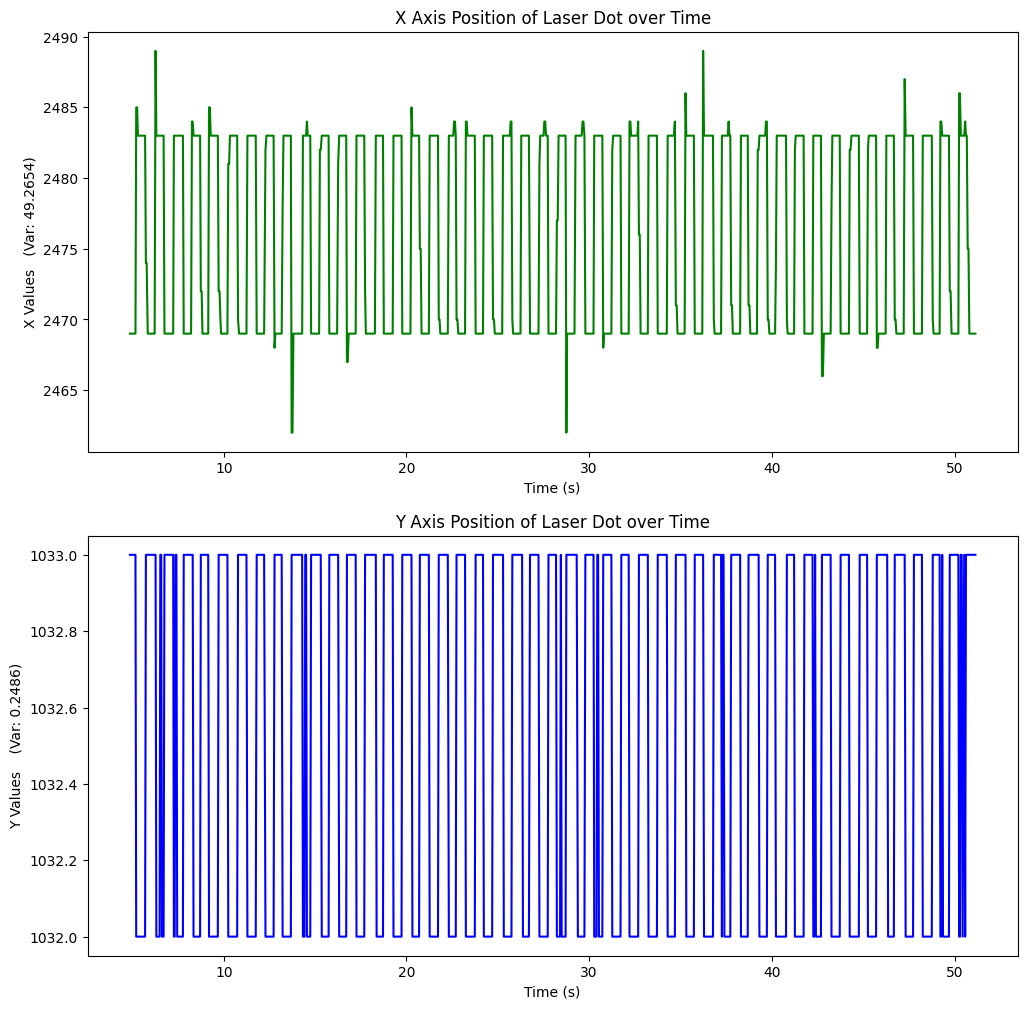

In [14]:
results = load_results(root_dir, "optotune_fsm_square_.04A_KF0_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_MOU0.05_MEU0.5_C1_K3.csv", "2025-08-04")
time_results = results["Time"]
x_results = results["X"]
y_results = results["Y"]
print(f"Samples: {len(results)}")
print(f"Time: {max(time_results)}")
fig, axes = plt.subplots(2, 1, figsize=(12, 12))
axes[0].plot(time_results, x_results,color="g")
axes[0].set_title(f"X Axis Position of Laser Dot over Time")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel(f"X Values   (Var: {x_results.var():.4f})")


axes[1].plot( results["Time"], y_results, label=f"Variance {y_results.var()}",  color="b")
axes[1].set_title(f"Y Axis Position of Laser Dot over Time")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel(f"Y Values    (Var: {y_results.var():.4f})")

plt.show()


### Extracting predicted frequency of movement noise aswell as distinct frequencys

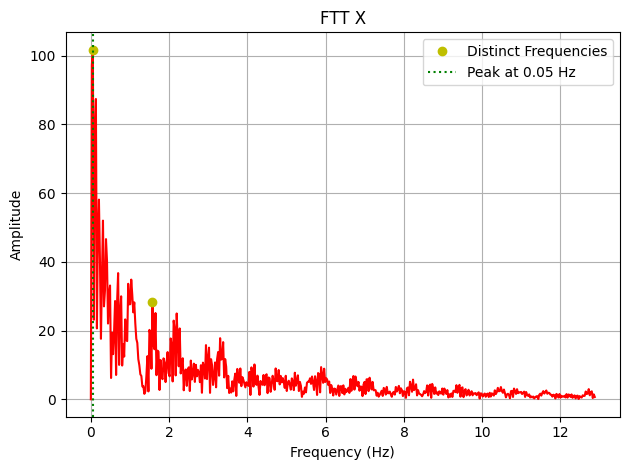

In [59]:
num_std_devs = 1
height = 0.5
x_frequencies, x_amplitudes = get_frequencies_and_amplitudes(x_results, np.array(time_results))
x_dominant_frequency = x_frequencies[np.argmax(x_amplitudes)]
x_distinct_peak_indices = get_distinct_peak_indices(x_frequencies, x_amplitudes, num_std_devs, height)
plt.plot(x_frequencies, x_amplitudes,  color='r')
plt.plot(x_frequencies[x_distinct_peak_indices], x_amplitudes[x_distinct_peak_indices],  'yo', label= "Distinct Frequencies")

plt.title('FTT X')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.axvline(x_dominant_frequency, color='g', linestyle=':', label=f'Peak at {x_dominant_frequency:.2f} Hz')
plt.legend()

plt.tight_layout()
plt.show()

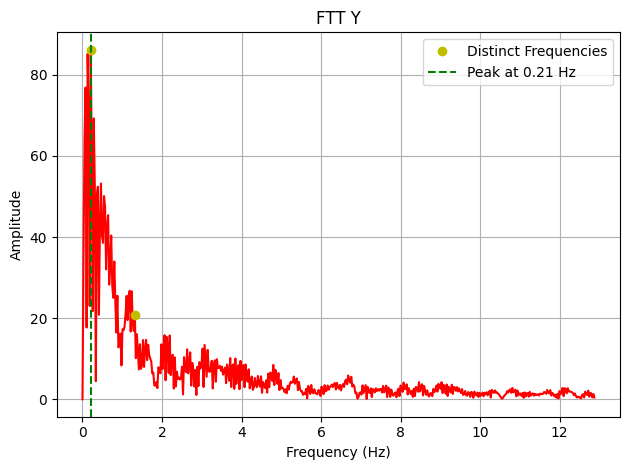

In [60]:
y_frequencies, y_amplitudes = get_frequencies_and_amplitudes(y_results, np.array(time_results))
y_dominant_frequency = y_frequencies[np.argmax(y_amplitudes)]
y_distinct_peak_indices = get_distinct_peak_indices(y_frequencies, y_amplitudes, num_std_devs, height)
plt.plot(y_frequencies, y_amplitudes,  color='r')
plt.plot(y_frequencies[y_distinct_peak_indices], y_amplitudes[y_distinct_peak_indices],  'yo'
         ,label= "Distinct Frequencies")

plt.title('FTT Y')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.axvline(y_dominant_frequency, color='g', linestyle='--', label=f'Peak at {y_dominant_frequency:.2f} Hz')
plt.legend()

plt.tight_layout()
plt.show()

### Error of actual frequency of movement noise and predicted frequency of noise

In [57]:
actual_frequency = 1.0
dominant_frequency = (x_dominant_frequency + y_dominant_frequency) / 2
error = (abs(dominant_frequency - actual_frequency) / actual_frequency) * 100
print(f"Error: {error:.2f}%")

Error: 1.36%


### Intensity varation with power of laser

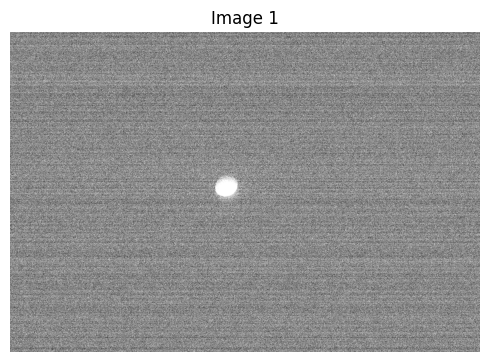

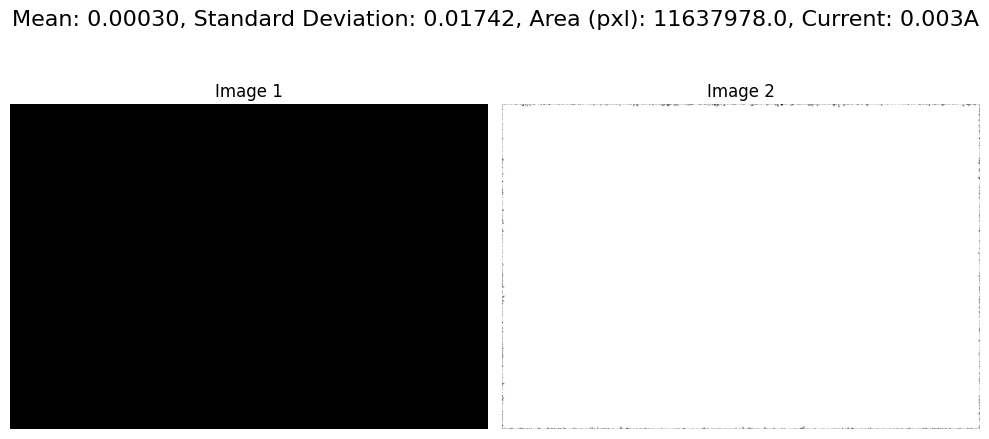

In [3]:
current = 0.003
current_unit: str = "A"
frames = 10
clean_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(frames)]
clean_image = np.median(clean_frames, axis = 0).astype(np.uint8)
contours = get_contours(clean_image)
if contours:
    lazer_blob = get_largest_contour(contours)
    mask = np.zeros(clean_image.shape, dtype=np.uint8)
    cv2.drawContours(mask,
                     [lazer_blob],
                     -1,
                     255,
                     thickness=cv2.FILLED)
    area = cv2.contourArea(lazer_blob) # Measured in pixels
    mean, std_dev = cv2.meanStdDev(clean_image, mask=mask)
    show_images(clean_image, mask, title= f"Mean: {mean[0,0]:.5f}, Standard Deviation: {std_dev[0,0]:.5f}, Area (pxl): {area}, Current: {current}{current_unit}")
else:
    area = 0.0
    mean = 0.0
    std_dev = 0.0
    show_images(clean_image, title= f"Couldn't find any contours, Mean: {mean:.5f}, Standard Deviation: {std_dev:.5f}, Area (pxl): {area}, Current: {current}{current_unit}")

### Intensity Results

In [4]:
camera.close()

In [66]:
error, mean, std_dev, current, area

(np.float64(48.207868486313856), 0.0, 0.0, 0.001, 0.0)

In [5]:
intensity_results = pd.DataFrame({
    "Frequency Error" : [
        48.2079, 71.3417, 74.1141, 3.017, 5.4405,
        4.2509, 0.7987, 4.1856, 2.6212, 1.2864,
        2.0884, 2.8698, 0.0767, 8.2045, 3.1407

    ],
    "Mean Intensity" : [
        0.0, 0.0, 0.0, 0.9962, 1.3467,
        2.6624, 9.1747, 19.4470, 34.7310, 52.8142,
        78.3584, 111.0976, 156.9581, 184.3910, 205.3289

    ],
    "Standard Deviation Intensity" : [
        0.0, 0.0, 0.0, 0.0613, 0.5073,
        0.7638, 3.4061, 7.5715, 12.5792, 20.0336,
        29.5215, 42.8003, 57.7703, 58.9460, 53.4733

    ],
    f"Current (A)" : [
        0.0, 0.001, 0.002, 0.003, 0.004,
        0.005, 0.01, 0.015, 0.02, 0.025,
        0.03, 0.035, 0.04, 0.045, 0.05

    ],
    f"Area (pxl)" : [
        0.0, 0.0, 0.0, 2021.0, 5292.0,
        4168.0, 6281.5, 6855.5, 6415.0, 6812.0,
        6810.5, 7013.0, 7178.0, 8979.5, 11202.0
    ]
})

### Measuring optical power with current

In [6]:
# At a power of 0.0 uW the current is also 0.0 A

power_current_measurements = pd.DataFrame({
    "Power (uW)" : [
        0.00348, 0.01442, 0.0338, 0.0578,
        0.0895, 0.317, 0.652, 1.106, 1.718,
        2.55, 3.74, 5.55, 8.47, 13.82
    ],
    f"Current (A)" : [
        0.001, 0.002, 0.003, 0.004,
        0.005, 0.01, 0.015, 0.02, 0.025,
        0.03, 0.035, 0.04, 0.045, 0.05
    ],
})
n = len(power_current_measurements)
k = sum([
    (power_current_measurements["Power (uW)"][i] / power_current_measurements["Current (A)"][i])
    for i in range(n)
]) / n
print(f"Constant: {k: .6f}")

Constant:  74.908764


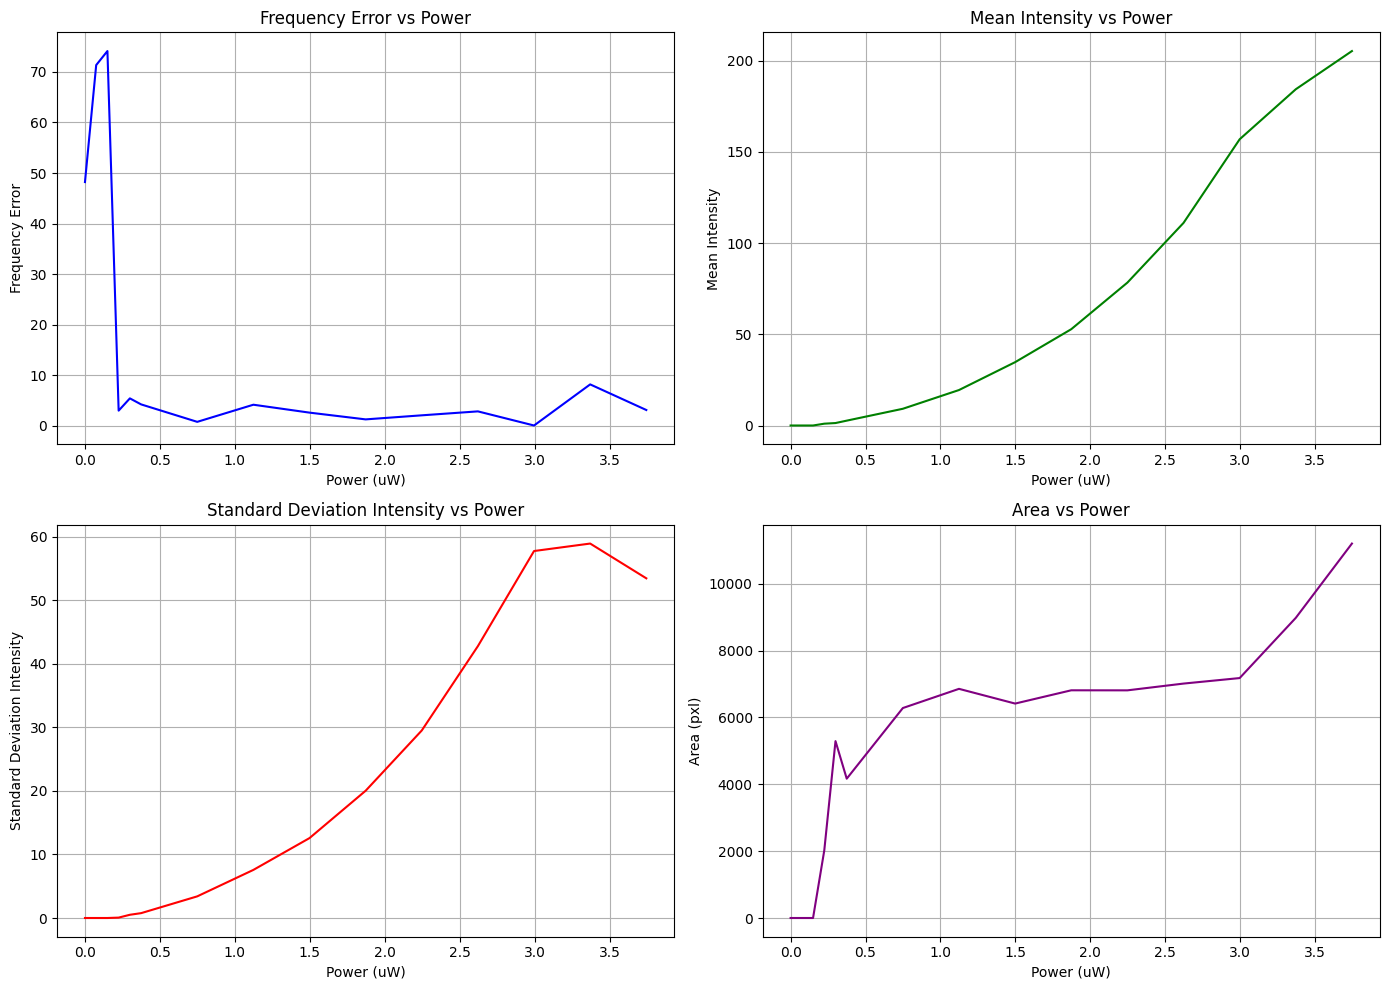

In [7]:
power = True

x_axis_unit = "uW" if power else "A"
x_axis_label= "Power" if power else "Current"
x_axis_data = intensity_results["Current (A)"] * k
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(x_axis_data, intensity_results["Frequency Error"], color='blue')
axes[0, 0].set_title(f"Frequency Error vs {x_axis_label}")
axes[0, 0].set_ylabel("Frequency Error")
axes[0, 0].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[0, 0].grid(True)

axes[0, 1].plot(x_axis_data, intensity_results["Mean Intensity"], color='green')
axes[0, 1].set_title(f"Mean Intensity vs {x_axis_label}")
axes[0, 1].set_ylabel("Mean Intensity")
axes[0, 1].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[0, 1].grid(True)

axes[1, 0].plot(x_axis_data, intensity_results["Standard Deviation Intensity"], color='red')
axes[1, 0].set_title(f"Standard Deviation Intensity vs {x_axis_label}")
axes[1, 0].set_ylabel("Standard Deviation Intensity")
axes[1, 0].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[1, 0].grid(True)

axes[1, 1].plot(x_axis_data, intensity_results["Area (pxl)"], color='purple')
axes[1, 1].set_title(f"Area vs {x_axis_label}")
axes[1, 1].set_ylabel("Area (pxl)")
axes[1, 1].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


### Plots that are independent of the area of the lazer

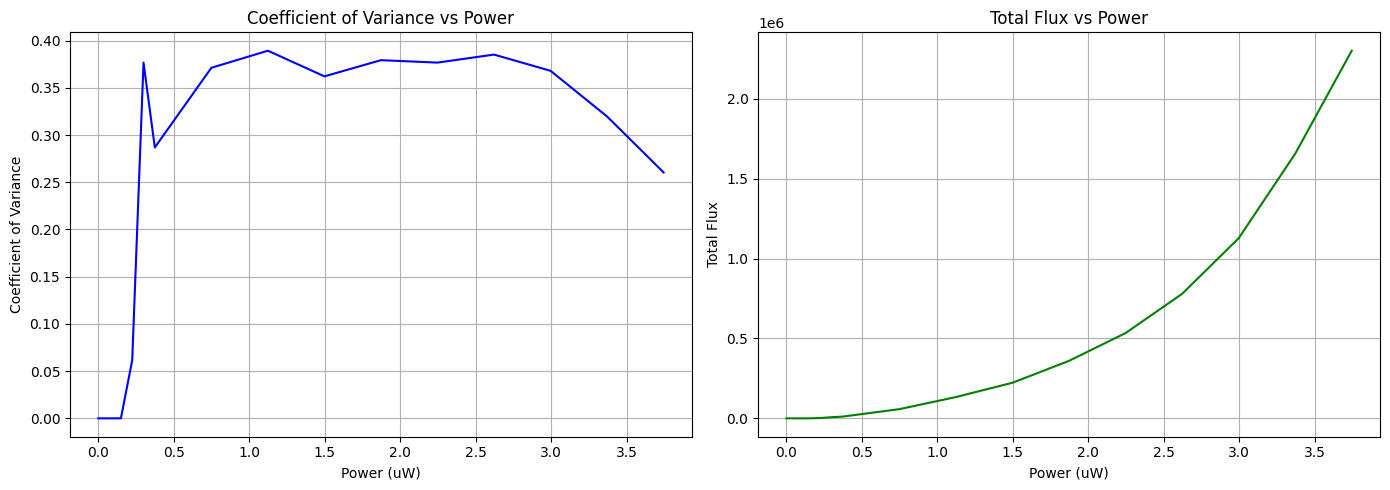

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

coefficient_of_variance = intensity_results["Standard Deviation Intensity"] / (intensity_results["Mean Intensity"] + 1e-9)
axes[0].plot(x_axis_data, coefficient_of_variance, color='blue')
axes[0].set_title(f"Coefficient of Variance vs {x_axis_label}")
axes[0].set_ylabel("Coefficient of Variance")
axes[0].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[0].grid(True)

total_flux = intensity_results["Mean Intensity"] * intensity_results["Area (pxl)"]
axes[1].plot(x_axis_data, total_flux, color='green')
axes[1].set_title(f"Total Flux vs {x_axis_label}")
axes[1].set_ylabel("Total Flux")
axes[1].set_xlabel(f"{x_axis_label} ({x_axis_unit})")
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Testing how frequency changes over time with amplitude

In [26]:
results_2 = load_results(root_dir, "square_A1.0Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_1_75 = load_results(root_dir, "square_A1.75Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_1_5 = load_results(root_dir, "square_A1.5Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_1_25 = load_results(root_dir, "square_A1.25Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_1 = load_results(root_dir, "square_A1.0Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_75 = load_results(root_dir, "square_A.75Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_5 = load_results(root_dir, "square_A.5Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_25 = load_results(root_dir, "square_A.25Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_15 = load_results(root_dir, "square_A.15Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_05 = load_results(root_dir, "square_A.05Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_025 = load_results(root_dir, "square_A.025Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")
results_0_001 = load_results(root_dir, "square_A.001Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv", "2025-07-28")

dict_results = {2.0 : results_2,
                1.75 : results_1_75,
                1.5 : results_1_5,
                1.25 : results_1_25,
                1.0 : results_1,
                0.75 : results_0_75,
                0.5 : results_0_5,
                0.25 : results_0_25,
                0.15 : results_0_15,
                0.05 : results_0_05,
                0.025 : results_0_025,
                0.001 : results_0_001
                }

Loaded square_A1.0Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-28
Loaded square_A1.75Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-28
Loaded square_A1.5Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-28
Loaded square_A1.25Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-28
Loaded square_A1.0Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_KF0_MOU0.05_MEU0.5_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-07-28
Loaded square_A.75Vpp_.003A_T180s_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_K

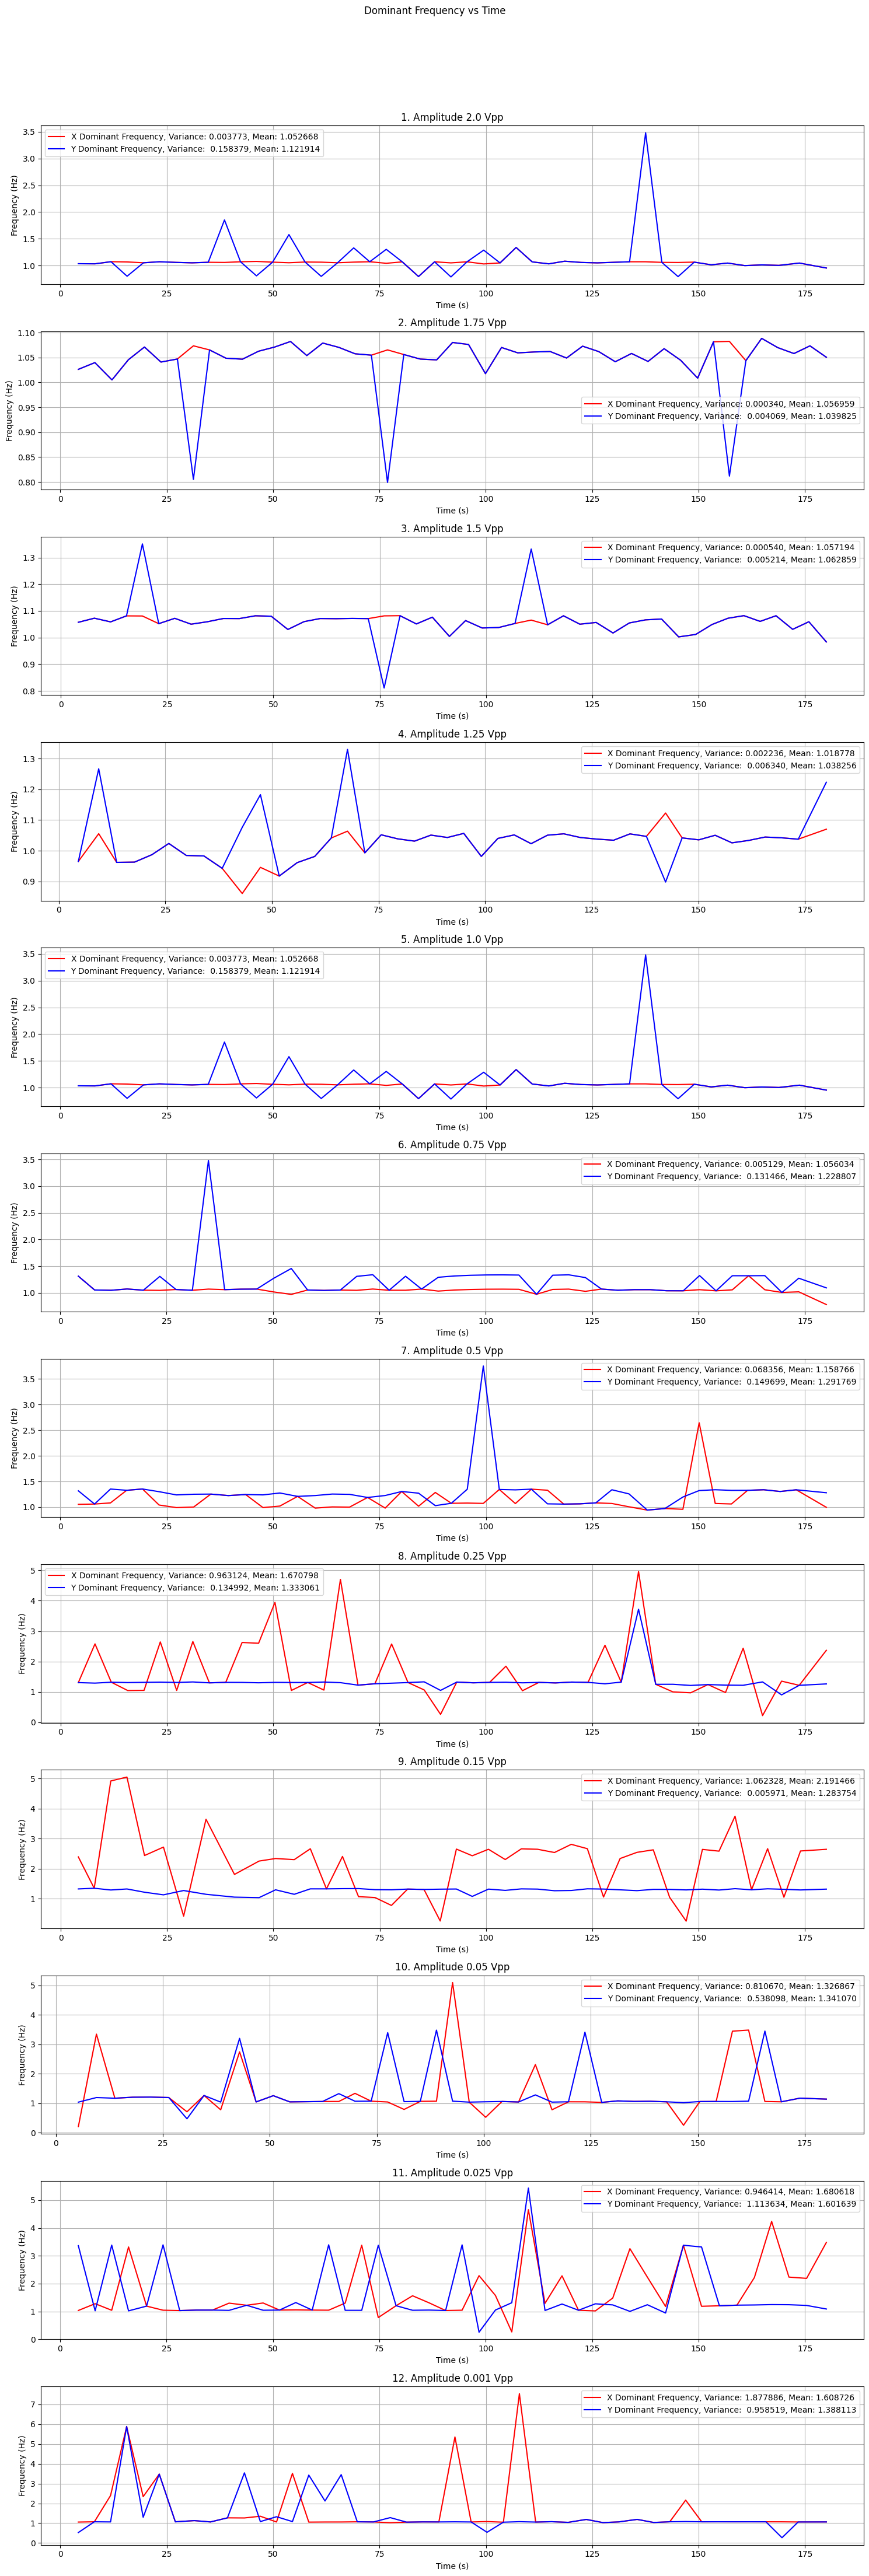

In [27]:
window_size = 100
dict_final_results = {}
for r_key in dict_results.keys():
    final_results = []
    r = dict_results[r_key]
    x_results = np.array(r["X"])
    y_results = np.array(r["Y"])
    times = np.array(r["Time"])
    for i in range(len(r) // window_size):
        start_idx = i * window_size
        if (i + 1) < len(r) // window_size:
            end_idx = start_idx + window_size
        else:
            end_idx = len(r) - 1
        x_frequencies, x_amplitudes = get_frequencies_and_amplitudes(np.array(x_results[start_idx:end_idx]), np.array(times[start_idx:end_idx]))
        y_frequencies, y_amplitudes = get_frequencies_and_amplitudes(np.array(y_results[start_idx:end_idx]), np.array(times[start_idx:end_idx]))
        final_results.append(
            (x_frequencies[np.argmax(x_amplitudes)],
             y_frequencies[np.argmax(y_amplitudes)],
             times[end_idx])
        )
    dict_final_results[r_key] = final_results

fig, axes = plt.subplots(len(dict_final_results), 1 , figsize=(15, 45))

for i, final_result_key in enumerate(dict_final_results.keys()):
    final_result = dict_final_results[final_result_key]
    x_dominant_frequencies, y_dominant_frequencies, times = zip(*final_result)
    x_variance = np.var(x_dominant_frequencies)
    y_variance = np.var(y_dominant_frequencies)
    x_mean = np.mean(x_dominant_frequencies)
    y_mean = np.mean(y_dominant_frequencies)
    axes[i].set_title(f"{i+1}. Amplitude {final_result_key} Vpp")

    axes[i].plot(times, x_dominant_frequencies, color='r', label=f'X Dominant Frequency, Variance: {x_variance:.6f}, Mean: {x_mean:.6f}')
    axes[i].plot(times, y_dominant_frequencies, color='b', label=f'Y Dominant Frequency, Variance: {y_variance: .6f}, Mean: {y_mean:.6f}')

    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Frequency (Hz)')
    axes[i].grid(True)
    axes[i].legend()

fig.suptitle('Dominant Frequency vs Time')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

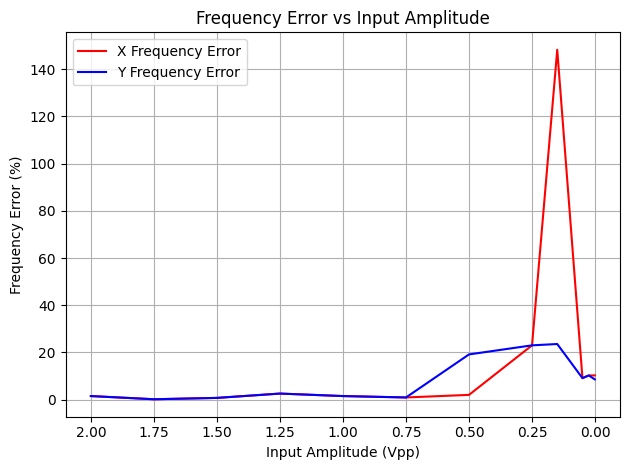

In [28]:
dict_final_results = {}
for r_key in dict_results.keys():
    r = dict_results[r_key]
    x_results = np.array(r["X"])
    y_results = np.array(r["Y"])
    times = np.array(r["Time"])
    x_frequencies, x_amplitudes = get_frequencies_and_amplitudes(np.array(x_results), np.array(times))
    y_frequencies, y_amplitudes = get_frequencies_and_amplitudes(np.array(y_results), np.array(times))

    dict_final_results[r_key] = (x_frequencies[np.argmax(x_amplitudes)],
         y_frequencies[np.argmax(y_amplitudes)],)

actual_frequency = 1.0
x_dominant_frequencies, y_dominant_frequencies = zip(*dict_final_results.values())
x_error = (abs(np.array(x_dominant_frequencies) - actual_frequency) / actual_frequency) * 100
y_error = (abs(np.array(y_dominant_frequencies) - actual_frequency) / actual_frequency) * 100

plt.plot(dict_final_results.keys(), x_error, color='r', label=f'X Frequency Error')
plt.plot(dict_final_results.keys(), y_error, color='b', label=f'Y Frequency Error')
plt.legend()
plt.gca().invert_xaxis()
plt.title("Frequency Error vs Input Amplitude")
plt.xlabel("Input Amplitude (Vpp)")
plt.ylabel("Frequency Error (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Get Desired fsm roi

In [27]:
bounds = get_fsm_roi_and_amplitude_bounds(camera, master_dark, fsm_controller,
                                          bins= BINS,
                                          max_resolution= MAX_RESOLUTION,)

Sent: xy=0;0
Pos (2527.0, 1176.0)
Pos (2519.0, 1176.0)
Pos (2508.0, 1176.0)
Pos (2500.0, 1177.0)
Pos (2490.0, 1177.0)
Pos (2482.0, 1177.0)
Pos (2471.0, 1177.0)
Pos (2463.0, 1178.0)
Pos (2453.0, 1178.0)
Pos (2445.0, 1178.0)
Pos (2435.0, 1178.0)
Pos (2425.0, 1178.0)
Pos (2416.0, 1179.0)
Pos (2407.0, 1179.0)
Pos (2398.0, 1179.0)
Pos (2389.0, 1179.0)
Pos (2379.0, 1180.0)
Pos (2370.0, 1180.0)
Pos (2360.0, 1180.0)
Pos (2351.0, 1180.0)
Pos (2342.0, 1181.0)
Pos (2332.0, 1181.0)
Pos (2323.0, 1181.0)
Pos (2313.0, 1181.0)
Pos (2304.0, 1181.0)
Pos (2294.0, 1181.0)
Pos (2285.0, 1182.0)
Pos (2276.0, 1182.0)
Pos (2267.0, 1182.0)
Pos (2258.0, 1182.0)
Pos (2249.0, 1182.0)
Pos (2240.0, 1182.0)
Pos (2231.0, 1182.0)
Pos (2222.0, 1182.0)
Pos (2213.0, 1183.0)
Pos (2204.0, 1183.0)
Pos (2195.0, 1183.0)
Pos (2186.0, 1183.0)
Pos (2177.0, 1183.0)
Pos (2169.0, 1183.0)
Pos (2160.0, 1184.0)
Pos (2151.0, 1184.0)
Pos (2142.0, 1184.0)
Pos (2133.0, 1184.0)
Pos (2124.0, 1184.0)
Pos (2115.0, 1185.0)
Pos (2106.0, 1185.0)


In [28]:
bounds2 = [1764.0, 3059.0, 2131.0, 499.0]
min_x, max_x, max_y, min_y = bounds2
max_width, max_height = MAX_RESOLUTION

padding = 20
final_width = int((np.ceil((max_x - min_x) + (padding * 2)) / 8.0)) * 8
final_height = int((np.ceil((max_y - min_y) + (padding * 2)) / 2.0)) * 2

start_x = max(0, int(min_x - padding))
start_y = max(0, int(min_y - padding))

if start_x + final_width > max_width:
    start_x = max_width - final_width
if start_y + final_height > max_height:
    start_y = max_height - final_height

resolution = (final_width, final_height)
start_pos = (start_x, start_y)

start_pos, resolution, final_width, final_height

((1744, 479), (1328, 1672), 1328, 1672)

### Testing movement of FSM laser point

Sent: x=0.02
Received: 
OK
APP X: 0.00010582010582010582 Y: 0.006666666666666667


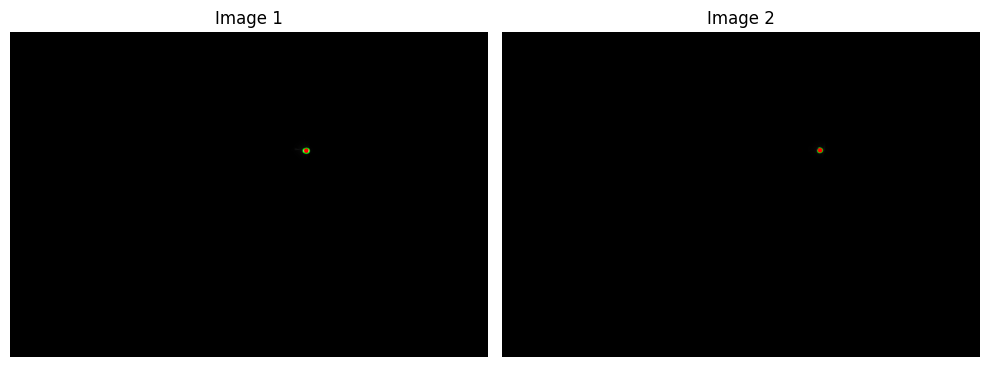

ORi, X: 2568.0 Y: 1029.0CAL, X: 2757.0 Y: 1026.0
Sent: xy=0;0
Received: 
OK


In [4]:
origin_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(10)]
origin_image = np.median(origin_frames, axis = 0).astype(np.uint8)


o_contours = get_contours(origin_image)
o_largest_contour = get_largest_contour(o_contours)
origin_x, origin_y = get_contour_origin(o_largest_contour)

origin_image = cv2.cvtColor(origin_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(
    image=origin_image,
    contours=o_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=8
)
cv2.circle(
    img=origin_image,
    center=(int(origin_x), int(origin_y)),
    radius=20,
    color=(255, 0, 0),
    thickness=-1
)

amplitude = 0.02
fsm_controller.send_command(f"x={amplitude}")


calibrate_frames = [get_clean_frame(camera.capture(), master_dark) for _ in range(10)]
calibrate_image = np.median(calibrate_frames, axis = 0).astype(np.uint8)

c_contours = get_contours(calibrate_image)
c_largest_contour = get_largest_contour(c_contours)
calibrate_x, calibrate_y = get_contour_origin(c_largest_contour)

calibrate_image = cv2.cvtColor(calibrate_image, cv2.COLOR_GRAY2BGR)

cv2.drawContours(
    image=calibrate_image,
    contours=c_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=8
)
cv2.circle(
    img=calibrate_image,
    center=(int(calibrate_x), int(calibrate_y)),
    radius=20,
    color=(255, 0 ,0),
    thickness=-1
)

delta_x = abs(origin_x - calibrate_x)
delta_y = abs(origin_y - calibrate_y)

if delta_x == 0:
    delta_x += 1
print(f"APP X: {amplitude / delta_x} Y: {amplitude / delta_y}")

show_images(origin_image, calibrate_image, )
print(f"ORi, X: {origin_x} Y: {origin_y}"
      f"CAL, X: {calibrate_x} Y: {calibrate_y}")
fsm_controller.send_command("xy=0;0")

### Plotting beam movement with a changing amplitude/angle

Loaded distance_vs_amplitude_.04A_KF0_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_MOU0.1_MEU2_C1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-08


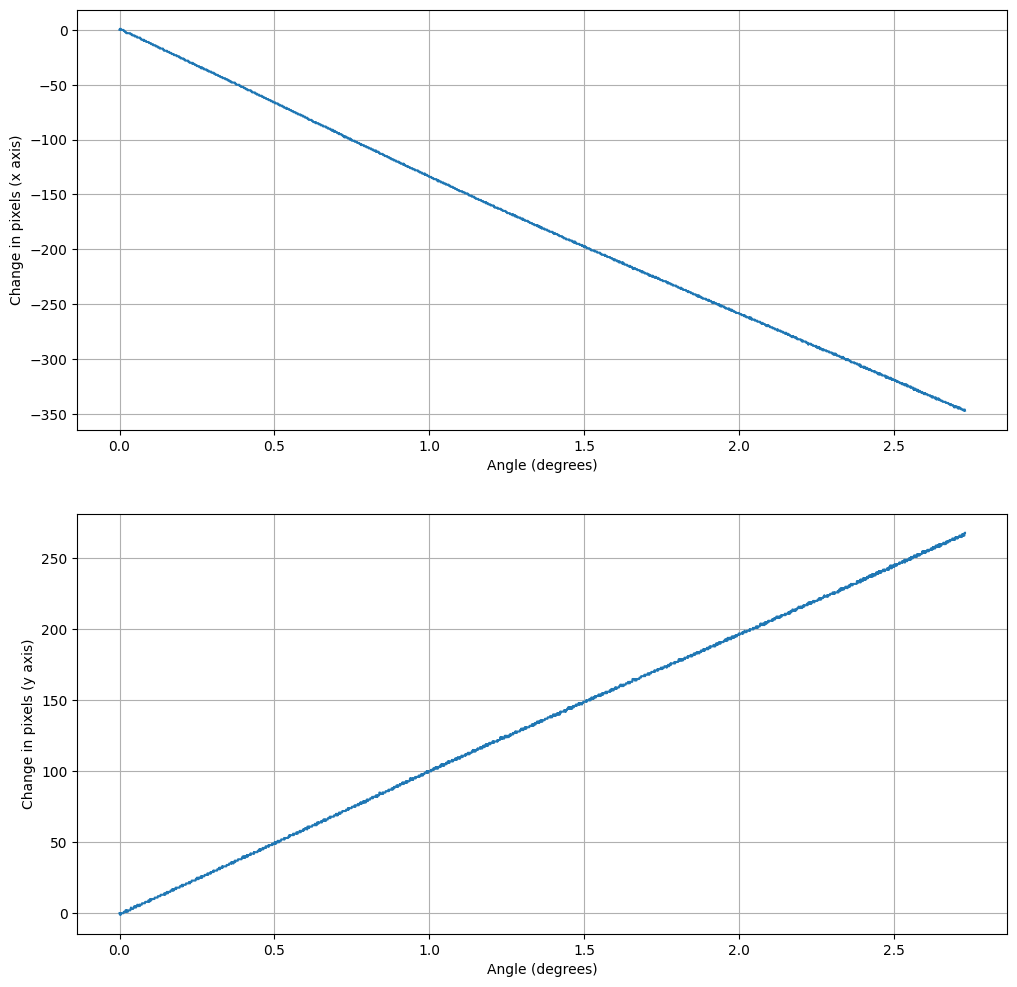

In [5]:
results = load_results(root_dir, "distance_vs_amplitude_.04A_KF0_G120_E32_B2_R(8288, 5640)_S(0, 0)_BC1_FSM0_MOU0.1_MEU2_C1_K3.csv", "2025-08-08")
angles = []
amplitude = 0.0
for _ in results.index:
    angles.append(math.degrees(math.atan(amplitude * math.tan(math.radians(50)))))
    amplitude += 0.00001
fig, ax = plt.subplots(2, 1, figsize = (12, 12))
ax[0].plot(angles, results["delta_x"])
ax[0].set_xlabel("Angle (degrees)")
ax[0].set_ylabel("Change in pixels (x axis)")
ax[0].grid()

ax[1].plot(angles, results["delta_y"])
ax[1].set_xlabel("Angle (degrees)")
ax[1].set_ylabel("Change in pixels (y axis)")
ax[1].grid()
plt.show()


Loading Results
Loaded noise_reduction_sine_.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM0_MOU0.05832_MEU0.00125_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-19

Loading Results
Loaded tracking_sine_G120_E32_B2_T0_KF0_MOU1e-06_MEU5.0_FR1.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-26



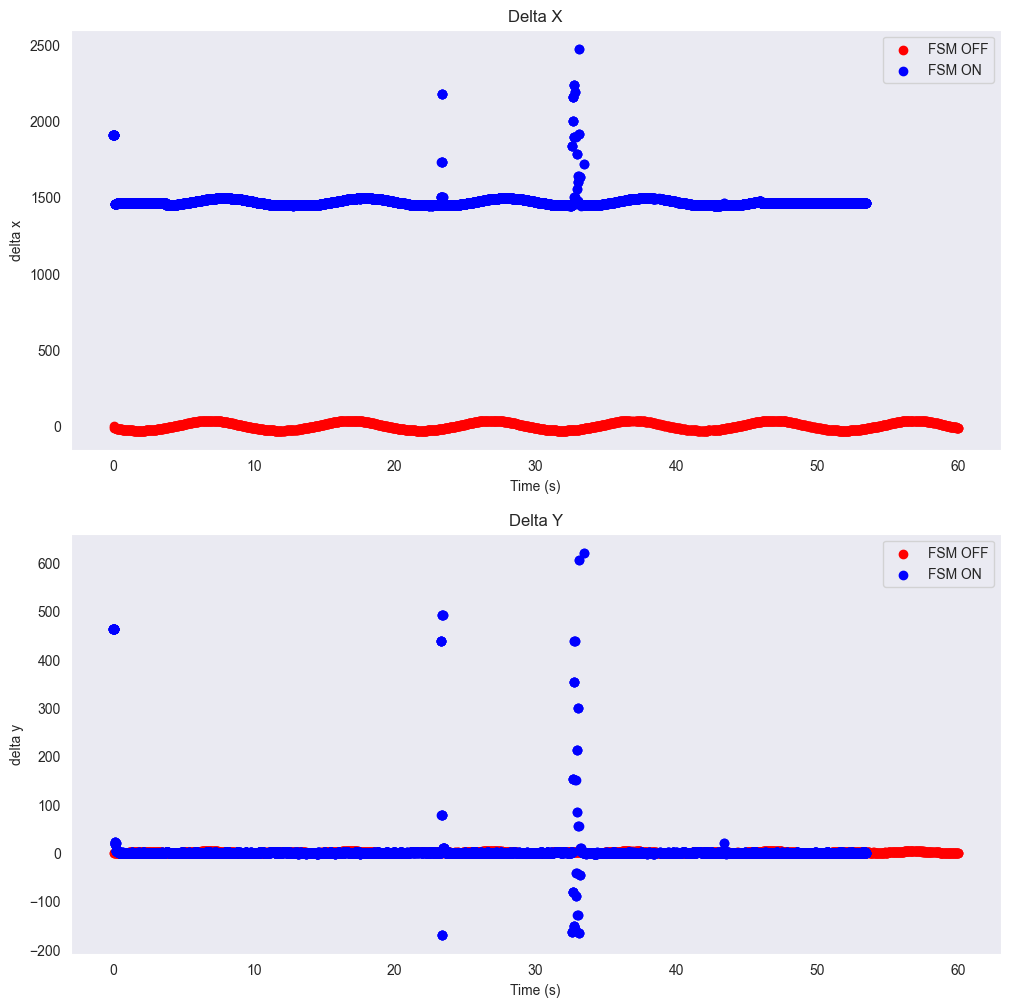

In [6]:
baseline_results = load_results(root_dir, "noise_reduction_sine_.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM0_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
results = load_results(root_dir, "tracking_sine_G120_E32_B2_T0_KF0_MOU1e-06_MEU5.0_FR1.csv", "2025-08-26")

fig, axis = plt.subplots(2, 1, figsize = (12, 12))
axis[0].scatter(baseline_results["Time"], baseline_results["delta_x"],  color = "r", label = "FSM OFF")
axis[0].scatter(results["Time"], results["delta_x"],  color = "b", label = "FSM ON")
axis[0].set_ylabel("delta x")
axis[0].set_xlabel("Time (s)")
axis[0].set_title("Delta X")
axis[0].grid()
axis[0].legend()

axis[1].scatter(baseline_results["Time"], baseline_results["delta_y"], color = "r", label = "FSM OFF")
axis[1].scatter(results["Time"], results["delta_y"], color = "b", label = "FSM ON")
axis[1].set_title("Delta Y")
axis[1].set_ylabel("delta y")
axis[1].set_xlabel("Time (s)")
axis[1].grid()
axis[1].legend()

plt.show()

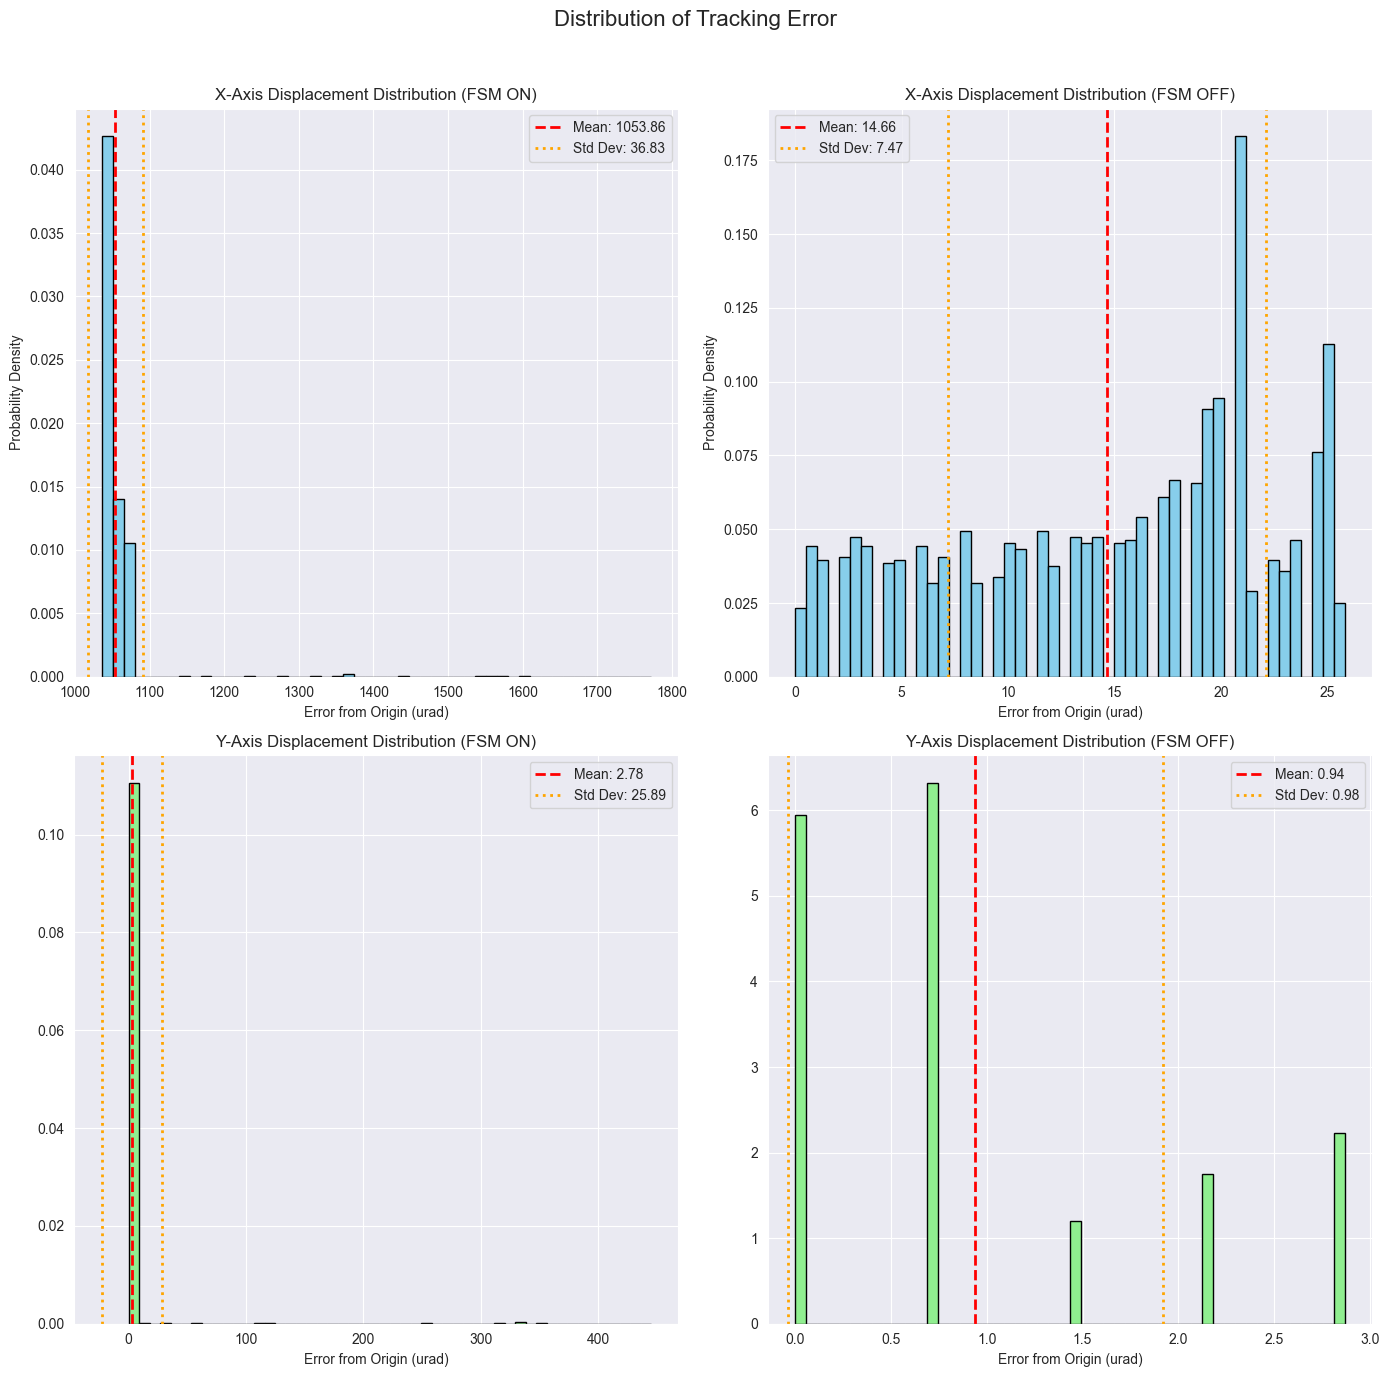

In [7]:
bin2_pixel_size = 4.63 #um

fig, ax = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle('Distribution of Tracking Error', fontsize=16)

displacement_x = np.array([2 * math.atan((abs(delta_pos) * bin2_pixel_size) / (2 * (6459 * 1e3))) * 1e6 for delta_pos in results["delta_x"]])
displacement_y = np.array([2 * math.atan((abs(delta_pos) * bin2_pixel_size) / (2 * (6459 * 1e3))) * 1e6 for delta_pos in results["delta_y"]])
baseline_displacement_x = np.array([2 * math.atan((abs(delta_pos) * bin2_pixel_size) / (2 * (6459 * 1e3))) * 1e6 for delta_pos in baseline_results["delta_x"]])
baseline_displacement_y = np.array([2 * math.atan((abs(delta_pos) * bin2_pixel_size) / (2 * (6459 * 1e3))) * 1e6 for delta_pos in baseline_results["delta_y"]])

ax1 = ax[0, 0]
ax1.hist(displacement_x, bins=50, density=True, color='skyblue', edgecolor='black')
ax1.set_title('X-Axis Displacement Distribution (FSM ON)')
ax1.set_xlabel('Error from Origin (urad)')
ax1.set_ylabel('Probability Density')
ax1.grid(True)
mean_x = displacement_x.mean()
std_x = displacement_x.std()
ax1.axvline(mean_x, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_x:.2f}')
ax1.axvline(mean_x + std_x, color='orange', linestyle=':', linewidth=2, label=f'Std Dev: {std_x:.2f}')
ax1.axvline(mean_x - std_x, color='orange', linestyle=':', linewidth=2)
ax1.legend()

ax2 = ax[1, 0]
ax2.hist(displacement_y, bins=50, density=True, color='lightgreen', edgecolor='black')
ax2.set_title('Y-Axis Displacement Distribution (FSM ON)')
ax2.set_xlabel('Error from Origin (urad)')
mean_y = displacement_y.mean()
std_y = displacement_y.std()
ax2.axvline(mean_y, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_y:.2f}')
ax2.axvline(mean_y + std_y, color='orange', linestyle=':', linewidth=2, label=f'Std Dev: {std_y:.2f}')
ax2.axvline(mean_y - std_y, color='orange', linestyle=':', linewidth=2)
ax2.legend()
ax2.grid(True)

ax3 = ax[0, 1]
ax3.hist(baseline_displacement_x, bins=50, density=True, color='skyblue', edgecolor='black')
ax3.set_title('X-Axis Displacement Distribution (FSM OFF)')
ax3.set_xlabel('Error from Origin (urad)')
ax3.set_ylabel('Probability Density')
ax3.grid(True)
mean_x = baseline_displacement_x.mean()
std_x = baseline_displacement_x.std()
ax3.axvline(mean_x, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_x:.2f}')
ax3.axvline(mean_x + std_x, color='orange', linestyle=':', linewidth=2, label=f'Std Dev: {std_x:.2f}')
ax3.axvline(mean_x - std_x, color='orange', linestyle=':', linewidth=2)
ax3.legend()

ax4 = ax[1, 1]
ax4.hist(baseline_displacement_y, bins=50, density=True, color='lightgreen', edgecolor='black')
ax4.set_title('Y-Axis Displacement Distribution (FSM OFF)')
ax4.set_xlabel('Error from Origin (urad)')
mean_y = baseline_displacement_y.mean()
std_y = baseline_displacement_y.std()
ax4.axvline(mean_y, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_y:.2f}')
ax4.axvline(mean_y + std_y, color='orange', linestyle=':', linewidth=2, label=f'Std Dev: {std_y:.2f}')
ax4.axvline(mean_y - std_y, color='orange', linestyle=':', linewidth=2)
ax4.legend()
ax4.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Testing to get minimum fsm down time between movement and camera capture

Loaded noise_reduction_sine_ST0.1.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-19
Loaded noise_reduction_sine_ST0.15.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-19
Loaded noise_reduction_sine_ST0.2.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-19
Loaded noise_reduction_sine_ST0.05.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-19
Loaded noise_reduction_sine_ST0.075.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-19
Loaded noise_reduction_sine_ST0.08125.04A

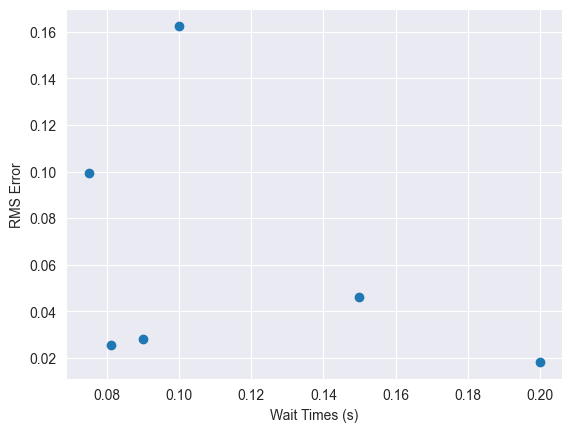

In [52]:
r0_1 = load_results(root_dir, "noise_reduction_sine_ST0.1.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r0_15 = load_results(root_dir, "noise_reduction_sine_ST0.15.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r0_2 = load_results(root_dir, "noise_reduction_sine_ST0.2.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r0_05 = load_results(root_dir, "noise_reduction_sine_ST0.05.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r0_075 = load_results(root_dir, "noise_reduction_sine_ST0.075.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r_0_08125 = load_results(root_dir, "noise_reduction_sine_ST0.08125.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
r0_09 = load_results(root_dir, "noise_reduction_sine_ST0.09.04A_KF0_G120_E32_B2_R(3008, 2820)_S(1136, 0)_FSM1_MOU0.05832_MEU0.00125_K3.csv", "2025-08-19")
results = {
    "0.1" : r0_1,
    "0.15" : r0_15,
    "0.2" : r0_2,
    "0.075" : r0_075,
    "0.08125" : r_0_08125,
    "0.09" : r0_09
}

results = {float(key) : np.sqrt(np.mean(results[key]['delta_x'], axis = 0)**2 + np.mean(results[key]['delta_y'], axis = 0)**2) for key in results.keys()}
print(results)

plt.scatter(results.keys(), results.values())
plt.ylabel("RMS Error")
plt.xlabel("Wait Times (s)")

plt.show()


Loaded tracking_.04A_KF0_G120_E32_B2_R(4144, 2820)_S(0, 0)_FSM0_MOU1e-06_MEU5_.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-22


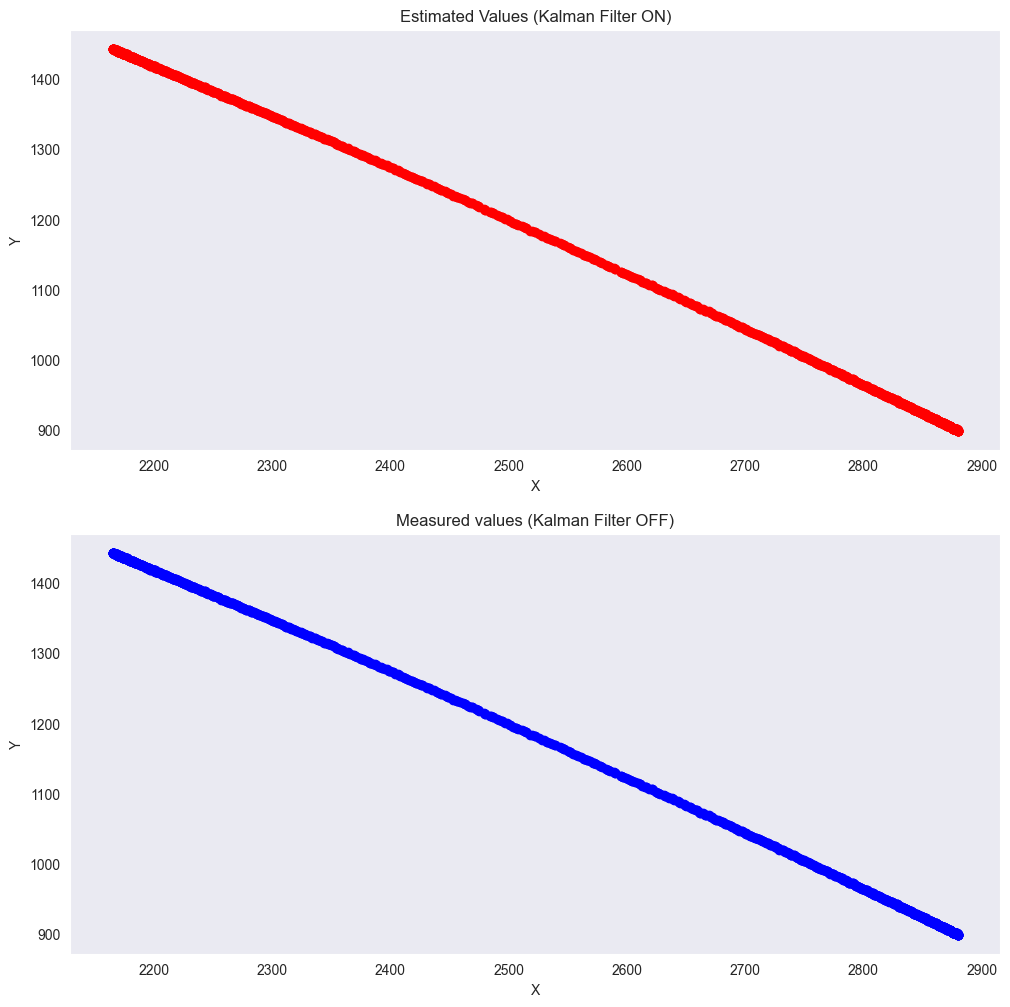

In [57]:
results = load_results(root_dir, "tracking_.04A_KF0_G120_E32_B2_R(4144, 2820)_S(0, 0)_FSM0_MOU1e-06_MEU5_.csv", "2025-08-22")

Q1 = results.quantile(0.25)
Q3 = results.quantile(0.75)
IQR = Q3 - Q1

results = results[~((results < (Q1 - 1.5 * IQR)) | (results > (Q3 + 1.5 * IQR))).any(axis=1)]
fig, axis = plt.subplots(2, 1, figsize = (12, 12))
ax1 = axis[0]
ax1.scatter(results["estimated_X"], results["estimated_Y"],  color = "r")
ax1.set_ylabel("Y")
ax1.set_xlabel("X")
ax1.set_title("Estimated Values (Kalman Filter ON)")
ax1.grid()

ax2 = axis[1]
ax2.scatter(results["measured_X"], results["measured_Y"],  color = "b")
ax2.set_ylabel("Y")
ax2.set_xlabel("X")
ax2.set_title("Measured values (Kalman Filter OFF)")
ax2.grid()
plt.show()


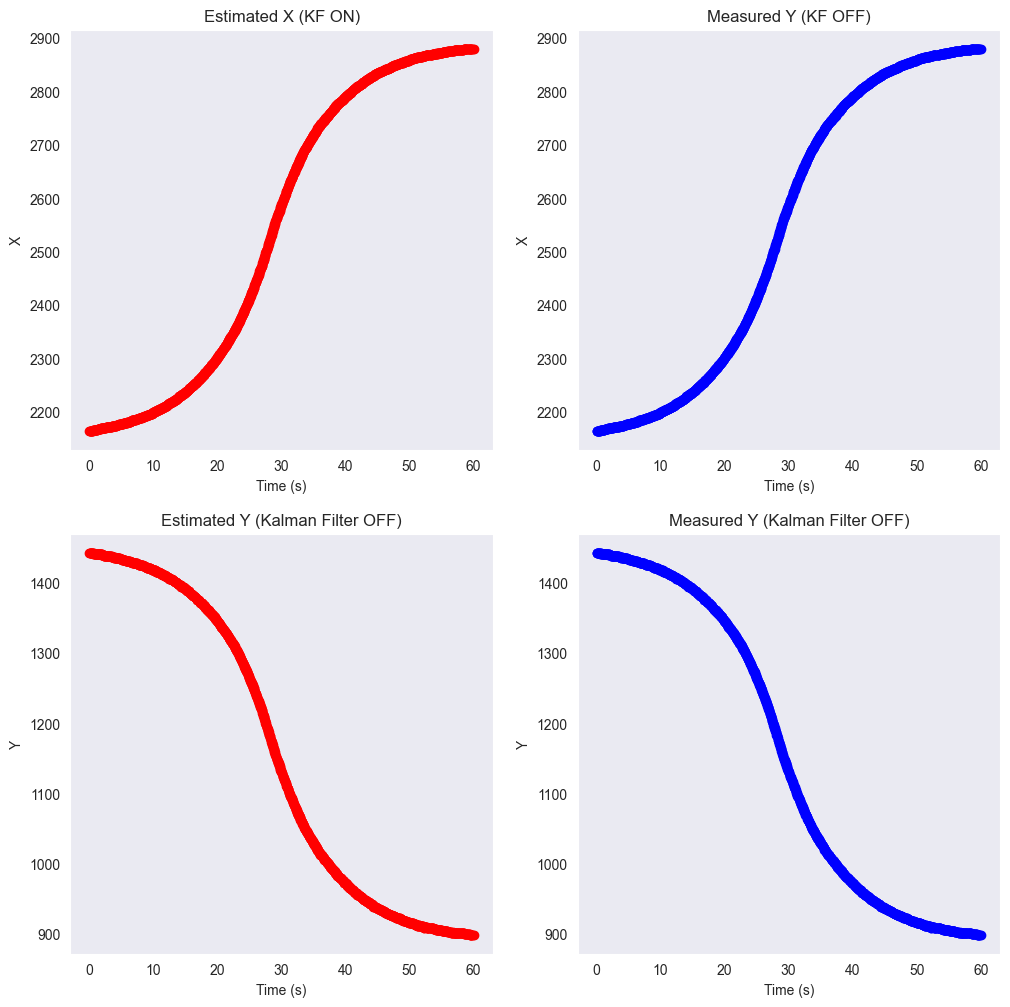

In [58]:
fig, axis = plt.subplots(2, 2, figsize = (12, 12))

ax1 = axis[0, 0]
ax1.scatter(results["Time"], results["estimated_X"],  color = "r")
ax1.set_ylabel("X")
ax1.set_xlabel("Time (s)")
ax1.set_title("Estimated X (KF ON)")
ax1.grid()

ax2 = axis[0, 1]
ax2.scatter(results["Time"], results["measured_X"],  color = "b")
ax2.set_ylabel("X")
ax2.set_xlabel("Time (s)")
ax2.set_title("Measured Y (KF OFF)")
ax2.grid()

ax3 = axis[1, 0]
ax3.scatter(results["Time"], results["estimated_Y"],  color = "r")
ax3.set_ylabel("Y")
ax3.set_xlabel("Time (s)")
ax3.set_title("Estimated Y (Kalman Filter OFF)")
ax3.grid()

ax4 = axis[1, 1]
ax4.scatter(results["Time"], results["measured_Y"],  color = "b")
ax4.set_ylabel("Y")
ax4.set_xlabel("Time (s)")
ax4.set_title("Measured Y (Kalman Filter OFF)")
ax4.grid()

plt.show()


### Tuning Kalman filters parameters

Loaded tuner_.04A_SI6_I300_G120_E32_B2_R(4144, 2820)_S(0, 0)_FSM1_K3.csv from directory: /Users/Eric/PycharmProjects/satelite_tracking/logs/2025-08-21
BEST PARAMETERS:
model_uncertainty          1.000000e-06
measurement_uncertainty    5.000000e+00
error_x                    1.558834e+00
error_y                    8.997087e-01
sane_rate                  9.966667e-01
cost                       4.204134e-02
Name: 35, dtype: float64


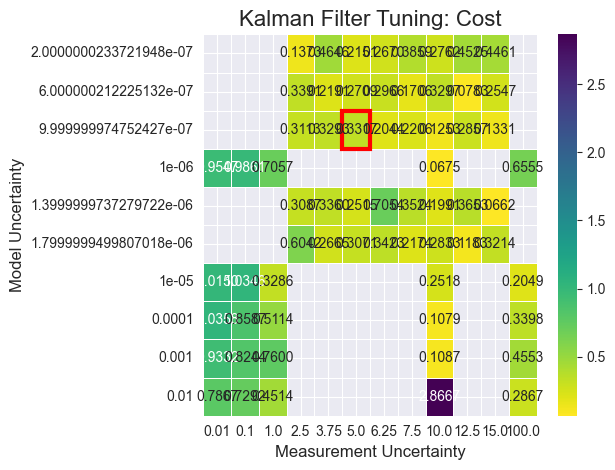

In [46]:
results = load_results(root_dir, "tuner_.04A_SI6_I300_G120_E32_B2_R(4144, 2820)_S(0, 0)_FSM1_K3.csv", "2025-08-21")

ERROR_WEIGHT = 2
SANE_WEIGHT = 1
rmse = np.sqrt(results['error_x']**2 + results['error_y']**2)
normalized_rmse = (rmse - rmse.min()) / (rmse.max() - rmse.min())
results["cost"] = (ERROR_WEIGHT * normalized_rmse) + \
                        (SANE_WEIGHT * (1 - results['sane_rate']))

heatmap_data = results.pivot_table(
    index='model_uncertainty',
    columns='measurement_uncertainty',
    values='cost'
)

best_params = results.loc[results['cost'].idxmin()]

ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="viridis_r",
    linewidths=.5
)

ax.set_title('Kalman Filter Tuning: Cost', fontsize=16)
ax.set_xlabel('Measurement Uncertainty', fontsize=12)
ax.set_ylabel('Model Uncertainty', fontsize=12)

best_q = best_params['model_uncertainty']
best_r = best_params['measurement_uncertainty']
print(f"BEST PARAMETERS:\n{best_params}")

best_y_idx = heatmap_data.index.get_loc(best_q)
best_x_idx = heatmap_data.columns.get_loc(best_r)

ax.add_patch(plt.Rectangle((best_x_idx, best_y_idx), 1, 1,
                            fill=False, edgecolor='red', lw=3))

plt.tight_layout()
plt.show()

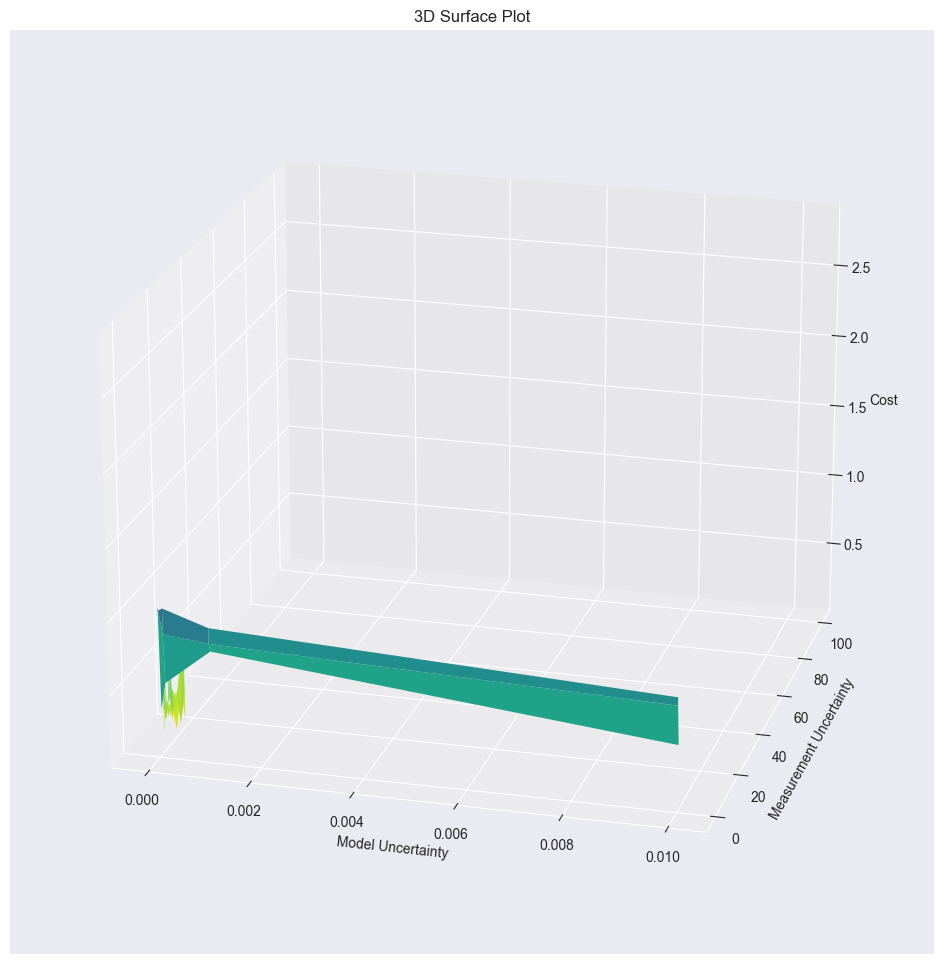

In [47]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
pivot_data = results.pivot_table(
    index='model_uncertainty',
    columns='measurement_uncertainty',
    values='cost'
)

X, Y = np.meshgrid(pivot_data.index.values, pivot_data.columns.values)
Z = pivot_data.T.values
surf = ax.plot_surface(X, Y, Z, cmap='viridis_r', edgecolor='none')
ax.set_title("3D Surface Plot")
ax.set_xlabel("Model Uncertainty")
ax.set_ylabel("Measurement Uncertainty")
ax.set_zlabel("Cost")
ax.view_init(elev=20, azim=-75)

plt.show()